*Here I will be performing the analysis for the final project. It includes looking at the -way bill data (a proxy for merchandise trade) and then inferring things about states based on that data.*

*This data will also be conbined with employment datasets to see if there is a commensurate rise in employment with an increase in trade, as represented by the E-Way Bill data.*

### Setting up the Imports

In [1]:
import polars as pl
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import ipywidgets as widgets
from ipywidgets import interact
import requests
import io
from shapely import wkt
import numpy as np
from datetime import datetime

In [2]:
e_way_bill_data = pl.read_csv("Datasets/India_EWay_Bills.csv")

**The dataset contains 7 unique values for e-way bill data, that can fundamentally be broken down into 3 categories: Incoming Trade to States, Outgoing Trade from States, and Trade inside a state**

**To properly analyze the data, and use concepts of DRY (Don't repeat yourself), I will create a function and pass values for each state, to generate data for that particular state**

## First Generating some All India Level Analysis

**As there is no "All-India" value in the State/UT name column, I will aggregate the data over a month, sum up the values for all states, and generate all India level insights based on that**

In [3]:
e_way_bill_data

shape: (9_510, 8)
┌─────────┬─────────────┬───────┬─────────────┬─────────────┬────────────┬────────────┬────────────┐
│ Country ┆ Year        ┆ Month ┆ State/Ut    ┆ Type Of     ┆ E-Way      ┆ E-Way      ┆ Assessable │
│ ---     ┆ ---         ┆ ---   ┆ Name        ┆ Supply      ┆ Suppliers  ┆ Bills (UOM ┆ Value (UOM │
│ str     ┆ str         ┆ str   ┆ ---         ┆ ---         ┆ (UOM:Numbe ┆ :Number),  ┆ :INR(Indi… │
│         ┆             ┆       ┆ str         ┆ str         ┆ r), …      ┆ Scal…      ┆ ---        │
│         ┆             ┆       ┆             ┆             ┆ ---        ┆ ---        ┆ f64        │
│         ┆             ┆       ┆             ┆             ┆ i64        ┆ i64        ┆            │
╞═════════╪═════════════╪═══════╪═════════════╪═════════════╪════════════╪════════════╪════════════╡
│ India   ┆ Calendar    ┆ June, ┆ ANDAMAN AND ┆ INCOMING    ┆ 1141       ┆ 11020      ┆ 387.5002   │
│         ┆ Year (Jan - ┆ 2025  ┆ NICOBAR     ┆ FROM OTHER  ┆            ┆            ┆            │
│         ┆ Dec), 202…  ┆       ┆             ┆ STATES      ┆            ┆            ┆            │
│ India   ┆ Calendar    ┆ June, ┆ ANDAMAN AND ┆ OUTGOING TO ┆ 118        ┆ 546        ┆ 100.3331   │
│         ┆ Year (Jan - ┆ 2025  ┆ NICOBAR     ┆ OTHER       ┆            ┆            ┆            │
│         ┆ Dec), 202…  ┆       ┆             ┆ STATES      ┆            ┆            ┆            │
│ India   ┆ Calendar    ┆ June, ┆ ANDAMAN AND ┆ WITHIN-STAT ┆ 104        ┆ 2686       ┆ 47.3962    │
│         ┆ Year (Jan - ┆ 2025  ┆ NICOBAR     ┆ E           ┆            ┆            ┆            │
│         ┆ Dec), 202…  ┆       ┆             ┆             ┆            ┆            ┆            │
│ India   ┆ Calendar    ┆ June, ┆ ANDHRA      ┆ INCOMING    ┆ 77195      ┆ 1169970    ┆ 43477.7937 │
│         ┆ Year (Jan - ┆ 2025  ┆ PRADESH     ┆ FROM OTHER  ┆            ┆            ┆            │
│         ┆ Dec), 202…  ┆       ┆             ┆ STATES      ┆            ┆            ┆            │
│ India   ┆ Calendar    ┆ June, ┆ ANDHRA      ┆ OUTGOING TO ┆ 23882      ┆ 592254     ┆ 45238.813  │
│         ┆ Year (Jan - ┆ 2025  ┆ PRADESH     ┆ OTHER       ┆            ┆            ┆            │
│         ┆ Dec), 202…  ┆       ┆             ┆ STATES      ┆            ┆            ┆            │
│ …       ┆ …           ┆ …     ┆ …           ┆ …           ┆ …          ┆ …          ┆ …          │
│ India   ┆ Calendar    ┆ July, ┆ UTTARAKHAND ┆ Inter State ┆ 18987      ┆ 406753     ┆ 12250.3840 │
│         ┆ Year (Jan - ┆ 2018  ┆             ┆ Inward      ┆            ┆            ┆ 24         │
│         ┆ Dec), 201…  ┆       ┆             ┆ Supplies    ┆            ┆            ┆            │
│ India   ┆ Calendar    ┆ July, ┆ UTTARAKHAND ┆ Inter State ┆ 6308       ┆ 298486     ┆ 15067.0813 │
│         ┆ Year (Jan - ┆ 2018  ┆             ┆ Outward     ┆            ┆            ┆ 87         │
│         ┆ Dec), 201…  ┆       ┆             ┆ Supplies    ┆            ┆            ┆            │
│ India   ┆ Calendar    ┆ July, ┆ WEST BENGAL ┆ INTRA STATE ┆ 34335      ┆ 1099145    ┆ 33581.5129 │
│         ┆ Year (Jan - ┆ 2018  ┆             ┆ SUPPLIES    ┆            ┆            ┆ 53         │
│         ┆ Dec), 201…  ┆       ┆             ┆             ┆            ┆            ┆            │
│ India   ┆ Calendar    ┆ July, ┆ WEST BENGAL ┆ Inter State ┆ 50570      ┆ 762564     ┆ 32974.4592 │
│         ┆ Year (Jan - ┆ 2018  ┆             ┆ Inward      ┆            ┆            ┆ 92         │
│         ┆ Dec), 201…  ┆       ┆             ┆ Supplies    ┆            ┆            ┆            │
│ India   ┆ Calendar    ┆ July, ┆ WEST BENGAL ┆ Inter State ┆ 34375      ┆ 570188     ┆ 25342.3983 │
│         ┆ Year (Jan - ┆ 2018  ┆             ┆ Outward     ┆            ┆            ┆ 19         │
│         ┆ Dec), 201…  ┆       ┆             ┆ Supplies    ┆            ┆            ┆            │
└─────────┴─────────────┴───────┴──────────

In [4]:
e_way_all_india = e_way_bill_data.select(
    pl.col("Month"),
    pl.col("State/Ut Name"),
    pl.col("E-Way Suppliers (UOM:Number), Scaling Factor:1").alias("Total E-way Bill Suppliers"),
    pl.col("E-Way Bills (UOM:Number), Scaling Factor:1").alias("Count of E-way Bill Generated"),
    pl.col("Assessable Value (UOM:INR(IndianRupees)), Scaling Factor:10000000").alias("Total E-way Bill Value")
).group_by(
    pl.col("Month")
).agg(
    pl.col("Total E-way Bill Suppliers").sum(),
    pl.col("Count of E-way Bill Generated").sum(),
    pl.col("Total E-way Bill Value").sum()
).with_columns(
    Formatted_Date = (pl.lit("1 ") + pl.col("Month")).str.to_date("%d %B, %Y")
).select(
    ["Formatted_Date", "Total E-way Bill Suppliers", "Count of E-way Bill Generated", "Total E-way Bill Value"]
).sort(
    pl.col("Formatted_Date")
)

e_way_all_india

shape: (84, 4)
┌────────────────┬──────────────────┬───────────────────────────────┬────────────────────────┐
│ Formatted_Date ┆ Total E-way Bill ┆ Count of E-way Bill Generated ┆ Total E-way Bill Value │
│ ---            ┆ Suppliers        ┆ ---                           ┆ ---                    │
│ date           ┆ ---              ┆ i64                           ┆ f64                    │
│                ┆ i64              ┆                               ┆                        │
╞════════════════╪══════════════════╪═══════════════════════════════╪════════════════════════╡
│ 2018-07-01     ┆ 2785209          ┆ 60068938                      ┆ 1.8275e6               │
│ 2018-08-01     ┆ 2984687          ┆ 67813434                      ┆ 2.0581e6               │
│ 2018-09-01     ┆ 2995804          ┆ 66976167                      ┆ 2.0537e6               │
│ 2018-10-01     ┆ 3254616          ┆ 73984944                      ┆ 2.2093e6               │
│ 2018-11-01     ┆ 3041802          ┆ 61277703                      ┆ 1.9384e6               │
│ …              ┆ …                ┆ …                             ┆ …                      │
│ 2025-02-01     ┆ 4711826          ┆ 148624718                     ┆ 3.9423e6               │
│ 2025-03-01     ┆ 4927584          ┆ 165391900                     ┆ 4.6115e6               │
│ 2025-04-01     ┆ 4725923          ┆ 158629324                     ┆ 4.0815e6               │
│ 2025-05-01     ┆ 4779080          ┆ 162174573                     ┆ 4.2123e6               │
│ 2025-06-01     ┆ 4669897          ┆ 157695640                     ┆ 4.0715e6               │
└────────────────┴──────────────────┴───────────────────────────────┴────────────────────────┘

### Generating Suppliers of E-Way Bills vs Time (All-India Level)

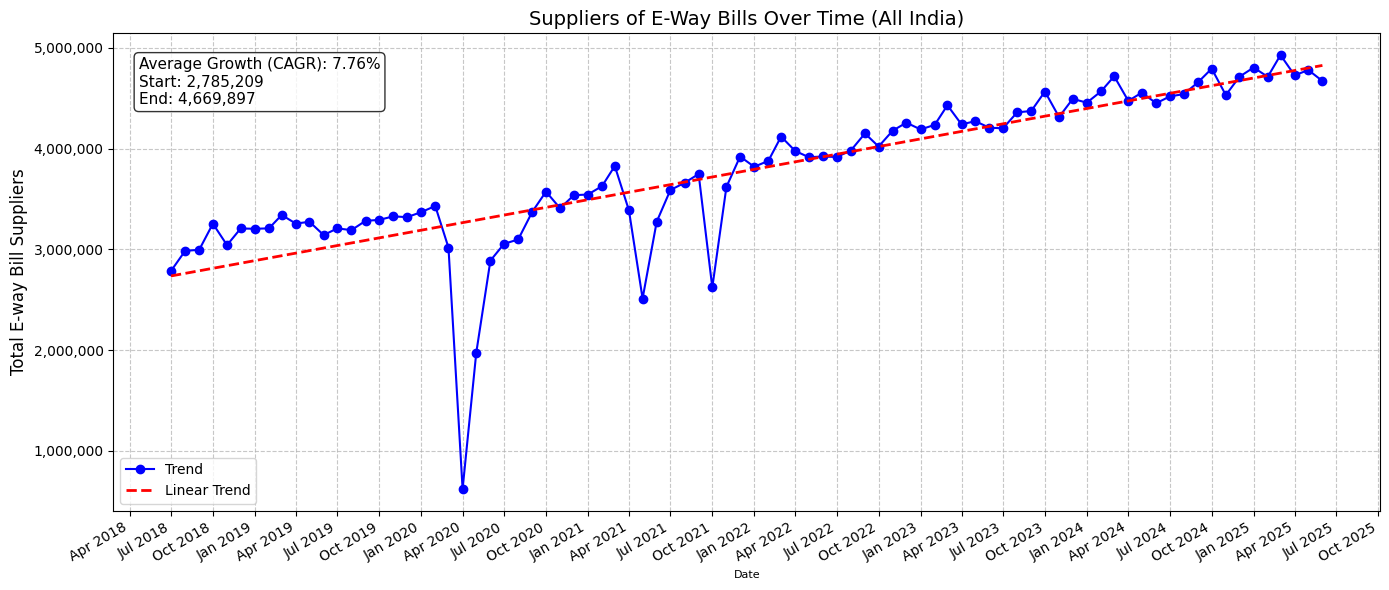

In [5]:
# Making calculations to show the overall trend rate in the plot below

x_dates = e_way_all_india["Formatted_Date"].to_list()
y_values = e_way_all_india["Total E-way Bill Suppliers"].to_list()
x_nums = mdates.date2num(x_dates)

z = np.polyfit(x_nums, y_values, 1)
p = np.poly1d(z)
trend_line_y = p(x_nums)

# CAGR Calculation
start_val = y_values[0]
end_val = y_values[-1]
num_years = (x_dates[-1] - x_dates[0]).days / 365.25
cagr = (end_val / start_val) ** (1 / num_years) - 1



# -------------------------------------- Visualization Starts Here ----------------------
plt.figure(figsize=(14, 6))

plt.plot(e_way_all_india["Formatted_Date"], e_way_all_india["Total E-way Bill Suppliers"], marker='o', linestyle='-', color='b', label='Trend')

# Plot Trend Line
plt.plot(x_dates, trend_line_y, color='red', linestyle='--', linewidth=2, label='Linear Trend')

# Add Text Box with Stats
text_str = f"Average Growth (CAGR): {cagr:.2%}\nStart: {start_val:,.0f}\nEnd: {end_val:,.0f}"
plt.gca().text(0.02, 0.95, text_str, transform=plt.gca().transAxes, fontsize=11,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
plt.gcf().autofmt_xdate()

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.title("Suppliers of E-Way Bills Over Time (All India)", fontsize=14)
plt.xlabel("Date", fontsize=8)
plt.ylabel("Total E-way Bill Suppliers", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

### Generating Count of E-Way Bills vs Time (All-India Level)

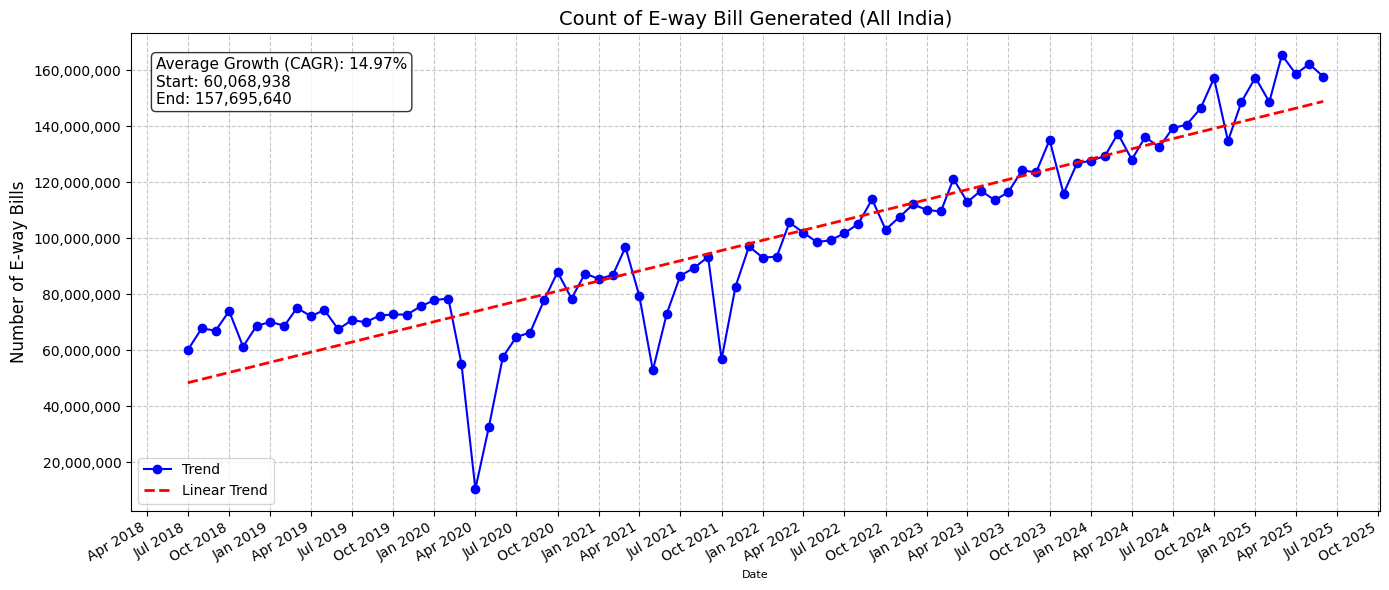

In [6]:
# Making calculations to show the overall trend rate in the plot below

x_dates = e_way_all_india["Formatted_Date"].to_list()
y_values = e_way_all_india["Count of E-way Bill Generated"].to_list()
x_nums = mdates.date2num(x_dates)

z = np.polyfit(x_nums, y_values, 1)
p = np.poly1d(z)
trend_line_y = p(x_nums)

# CAGR Calculation
start_val = y_values[0]
end_val = y_values[-1]
num_years = (x_dates[-1] - x_dates[0]).days / 365.25
cagr = (end_val / start_val) ** (1 / num_years) - 1



# -------------------------------------- Visualization Starts Here ----------------------
plt.figure(figsize=(14, 6))

plt.plot(e_way_all_india["Formatted_Date"], e_way_all_india["Count of E-way Bill Generated"], marker='o', linestyle='-', color='b', label='Trend')

# Plot Trend Line
plt.plot(x_dates, trend_line_y, color='red', linestyle='--', linewidth=2, label='Linear Trend')

# Add Text Box with Stats
text_str = f"Average Growth (CAGR): {cagr:.2%}\nStart: {start_val:,.0f}\nEnd: {end_val:,.0f}"
plt.gca().text(0.02, 0.95, text_str, transform=plt.gca().transAxes, fontsize=11,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
plt.gcf().autofmt_xdate()

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.title("Count of E-way Bill Generated (All India)", fontsize=14)
plt.xlabel("Date", fontsize=8)
plt.ylabel("Number of E-way Bills", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

### Generating Total E-way Bill Value vs Time (All-India Level)

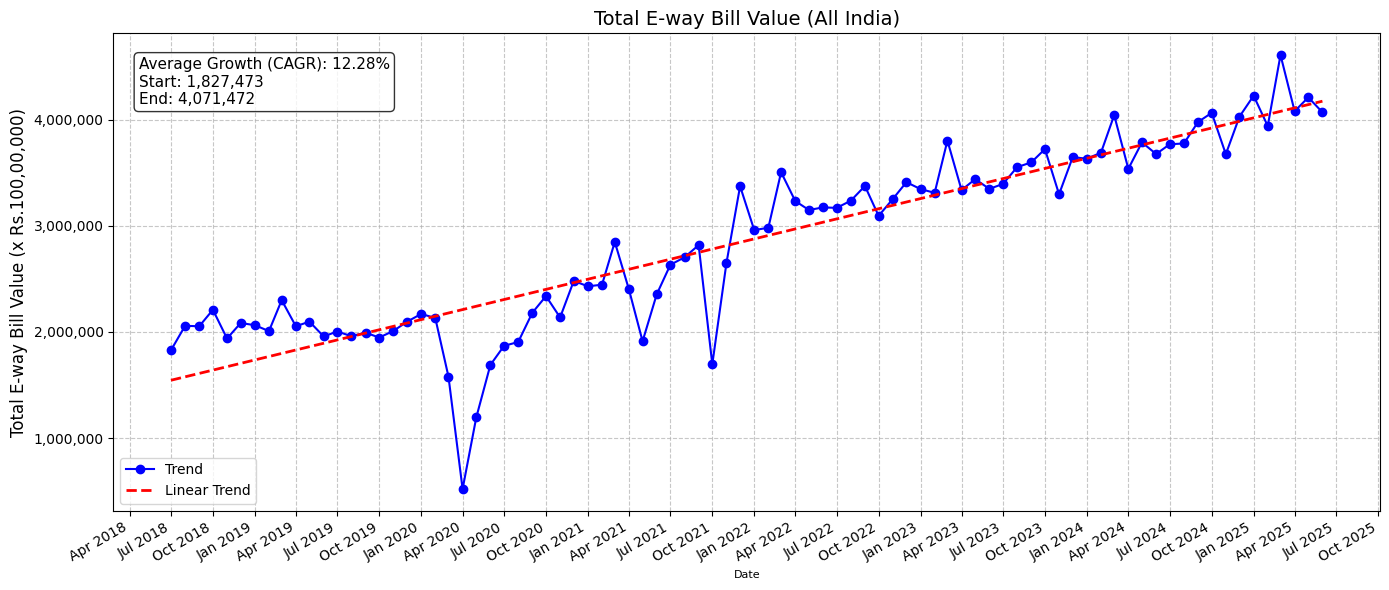

In [7]:
# Making calculations to show the overall trend rate in the plot below

x_dates = e_way_all_india["Formatted_Date"].to_list()
y_values = e_way_all_india["Total E-way Bill Value"].to_list()
x_nums = mdates.date2num(x_dates)

z = np.polyfit(x_nums, y_values, 1)
p = np.poly1d(z)
trend_line_y = p(x_nums)

# CAGR Calculation
start_val = y_values[0]
end_val = y_values[-1]
num_years = (x_dates[-1] - x_dates[0]).days / 365.25
cagr = (end_val / start_val) ** (1 / num_years) - 1



# -------------------------------------- Visualization Starts Here ----------------------
plt.figure(figsize=(14, 6))

plt.plot(e_way_all_india["Formatted_Date"], e_way_all_india["Total E-way Bill Value"], marker='o', linestyle='-', color='b', label='Trend')

# Plot Trend Line
plt.plot(x_dates, trend_line_y, color='red', linestyle='--', linewidth=2, label='Linear Trend')

# Add Text Box with Stats
text_str = f"Average Growth (CAGR): {cagr:.2%}\nStart: {start_val:,.0f}\nEnd: {end_val:,.0f}"
plt.gca().text(0.02, 0.95, text_str, transform=plt.gca().transAxes, fontsize=11,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
plt.gcf().autofmt_xdate()

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.title("Total E-way Bill Value (All India)", fontsize=14)
plt.xlabel("Date", fontsize=8)
plt.ylabel("Total E-way Bill Value (x Rs.100,00,000)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

## Finding the names of the States from the E-Way Bill CSV

In [8]:
indian_states = e_way_bill_data["State/Ut Name"].str.strip_chars().unique().sort().to_list()
indian_states = [state.strip() for state in indian_states]


## Calculating Important Metrics for Analysis

**1. Defining Functions for Finding the CAGR (Compound Annual Growth Rate) of Merchandise Trade. Components include:**

    1a. Incoming Trade

    1b. Outgoing Trade

    1c. Internal Trade (Within Trade)

    1d. Total Trade

---

***Methodology of finding Trade CAGR in the function below***

i) *First the overall dataset is taken and for each subcomponent (incoming / outgoing / within), a filtering of states is done.*

ii) *Then only the required columns are taken (month, count of e-way bills, value of e-way bills)*

iii) *The month column is then cleaned and converted to datetime format. This is stored in a new column called Formatted Date*

iv) *3 columns are then chosen (Formatted Date, count of e-way bills, value of e-way bills)*

v) *The dataframe is then sorted by the Date column in ascending order*

vi) *Using the sorted dataframe, the first and last 12 months of data is taken for value and count of e-way bills*

vii) *These first and last 12 months of data is then summed up and stored for calculation of CAGR*

viii) *The length of the data series is then calculated (allows us to expand the dataset later on from the Government's Open Data Platform). This will then be used to calculate the CAGR*

ix) *The formula for CAGR is then used to calculate the CAGR for each state, for both count and value of e-way bills, as a percentage*

x) *These calculated values are then returned.*

---

***In the function below, the total Trade CAGR `find_cagr_total` (combining internal + external + within trade) is calculated as follows:***

i) *Filter overall dataset to find all the trade data for the given state*

ii) *Select the columns of month, count and value of e-way bills*

iii) *Create a Formatted Date column (datetime) using the Month column*

iv) *Format the dataframe using the Formatted Date column*

v) *Group the dataframe using the Formatted Date column, and sum the value of count and value for each month. This will allow us to calculate the sum of count and value for incoming + outgoing + within trade*

vi) *Calculate the CAGR as above, using the first and last 12 months of data, and return the result*

In [9]:
def find_incoming_CAGR(state_name):
    df_incoming_cagr = e_way_bill_data.filter(
        pl.col("State/Ut Name") == state_name,
        pl.col("Type Of Supply").is_in(["INCOMING FROM OTHER STATES", "Inter State Inward Supplies"])
    ).select(
        pl.col("Month"),
        pl.col("E-Way Bills (UOM:Number), Scaling Factor:1").alias("Count of E-Way Bills"),
        pl.col("Assessable Value (UOM:INR(IndianRupees)), Scaling Factor:10000000").alias("Value of E-Way Bills")
    ).with_columns(
        Formatted_Date = (pl.lit("1 ") + pl.col("Month")).str.to_date("%d %B, %Y")
    ).select(
        pl.col("Formatted_Date"),
        pl.col("Count of E-Way Bills"),
        pl.col("Value of E-Way Bills")
    ).sort(
        pl.col("Formatted_Date")
    )
    
    sum_first_year_incoming_value = df_incoming_cagr["Value of E-Way Bills"].head(12).sum()
    sum_last_year_incoming_value = df_incoming_cagr["Value of E-Way Bills"].tail(12).sum()

    sum_first_year_incoming_count = df_incoming_cagr["Count of E-Way Bills"].head(12).sum()
    sum_last_year_incoming_count = df_incoming_cagr["Count of E-Way Bills"].tail(12).sum()

    n_years = (len(df_incoming_cagr) - 12) /12

    incoming_value_cagr = (((sum_last_year_incoming_value / sum_first_year_incoming_value) ** (1/n_years)) - 1) * 100
    incoming_count_cagr = (((sum_last_year_incoming_count / sum_first_year_incoming_count) ** (1/n_years)) - 1) * 100 

    return (incoming_value_cagr, incoming_count_cagr)

def find_outgoing_CAGR(state_name):
    df_outgoing_cagr = e_way_bill_data.filter(
        pl.col("State/Ut Name") == state_name,
        pl.col("Type Of Supply").is_in(["OUTGOING TO OTHER STATES", "Inter State Outward Supplies"])
    ).select(
        pl.col("Month"),
        pl.col("E-Way Bills (UOM:Number), Scaling Factor:1").alias("Count of E-Way Bills"),
        pl.col("Assessable Value (UOM:INR(IndianRupees)), Scaling Factor:10000000").alias("Value of E-Way Bills")
    ).with_columns(
        Formatted_Date = (pl.lit("1 ") + pl.col("Month")).str.to_date("%d %B, %Y")
    ).select(
        pl.col("Formatted_Date"),
        pl.col("Count of E-Way Bills"),
        pl.col("Value of E-Way Bills")
    ).sort(
        pl.col("Formatted_Date")
    )
    
    sum_first_year_outgoing_value = df_outgoing_cagr["Value of E-Way Bills"].head(12).sum()
    sum_last_year_outgoing_value = df_outgoing_cagr["Value of E-Way Bills"].tail(12).sum()

    sum_first_year_outgoing_count = df_outgoing_cagr["Count of E-Way Bills"].head(12).sum()
    sum_last_year_outgoing_count = df_outgoing_cagr["Count of E-Way Bills"].tail(12).sum()

    n_years = (len(df_outgoing_cagr) - 12) /12

    outgoing_value_cagr = (((sum_last_year_outgoing_value / sum_first_year_outgoing_value) ** (1/n_years)) - 1) * 100
    outgoing_count_cagr = (((sum_last_year_outgoing_count / sum_first_year_outgoing_count) ** (1/n_years)) - 1) * 100

    return (outgoing_value_cagr, outgoing_count_cagr)

def find_within_CAGR(state_name):
    df_within_cagr = e_way_bill_data.filter(
        pl.col("State/Ut Name") == state_name,
        pl.col("Type Of Supply").is_in(["WITHIN-STATE", "Intra State Supplies", "INTRA STATE SUPPLIES"])
    ).select(
        pl.col("Month"),
        pl.col("E-Way Bills (UOM:Number), Scaling Factor:1").alias("Count of E-Way Bills"),
        pl.col("Assessable Value (UOM:INR(IndianRupees)), Scaling Factor:10000000").alias("Value of E-Way Bills")
    ).with_columns(
        Formatted_Date = (pl.lit("1 ") + pl.col("Month")).str.to_date("%d %B, %Y")
    ).select(
        pl.col("Formatted_Date"),
        pl.col("Count of E-Way Bills"),
        pl.col("Value of E-Way Bills")
    ).sort(
        pl.col("Formatted_Date")
    )
    
    sum_first_year_within_value = df_within_cagr["Value of E-Way Bills"].head(12).sum()
    sum_last_year_within_value = df_within_cagr["Value of E-Way Bills"].tail(12).sum()

    sum_first_year_within_count = df_within_cagr["Count of E-Way Bills"].head(12).sum()
    sum_last_year_within_count = df_within_cagr["Count of E-Way Bills"].tail(12).sum()

    n_years = (len(df_within_cagr) - 12) /12

    within_value_cagr = (((sum_last_year_within_value / sum_first_year_within_value) ** (1/n_years)) - 1) * 100
    within_count_cagr = (((sum_last_year_within_count / sum_first_year_within_count) ** (1/n_years)) - 1) * 100

    return (within_value_cagr, within_count_cagr)

def find_cagr_total(state_name):
    df_total = e_way_bill_data.filter(
        pl.col("State/Ut Name") == state_name
    ).select(
        pl.col("Month"),
        pl.col("E-Way Bills (UOM:Number), Scaling Factor:1").alias("Count"),
        pl.col("Assessable Value (UOM:INR(IndianRupees)), Scaling Factor:10000000").alias("Value")
    ).with_columns(
        Formatted_Date = (pl.lit("1 ") + pl.col("Month")).str.to_date("%d %B, %Y")
    ).sort("Formatted_Date")


    df_grouped = df_total.group_by("Formatted_Date").agg(
        pl.col("Count").sum(),
        pl.col("Value").sum()
    ).sort("Formatted_Date")

    first_year_val = df_grouped["Value"].head(12).sum()
    last_year_val  = df_grouped["Value"].tail(12).sum()
    
    first_year_count = df_grouped["Count"].head(12).sum()
    last_year_count  = df_grouped["Count"].tail(12).sum()

    n_years = (len(df_grouped) - 12) /12

    total_value_cagr = (((last_year_val / first_year_val) ** (1/n_years)) - 1) * 100
    total_count_cagr = (((last_year_count / first_year_count) ** (1/n_years)) - 1) * 100

    return (total_value_cagr, total_count_cagr)


In [10]:
# Finding the Absolute Value of E-Way Bills for each state (in a function)
# Aim is to return values for Internal, External Trade Value
# The value over the latest 12 months is taken and then averaged and returned

def absolute_value_of_eway_bills(state):
    absolute_value_external = e_way_bill_data.filter(
        pl.col("State/Ut Name") == state,
        pl.col("Type Of Supply").is_in(["OUTGOING TO OTHER STATES", "Inter State Outward Supplies", "INCOMING FROM OTHER STATES", "Inter State Inward Supplies"])
    ).select(
        pl.col("Month"),
        pl.col("Assessable Value (UOM:INR(IndianRupees)), Scaling Factor:10000000").alias("Value of E-Way Bills")
    ).with_columns(
        Formatted_Date = (pl.lit("1 ") + pl.col("Month")).str.to_date("%d %B, %Y")
    ).sort("Formatted_Date").select(
        pl.col("Formatted_Date"),
        pl.col("Value of E-Way Bills")
    ).group_by("Formatted_Date").agg(
        pl.col("Value of E-Way Bills").sum()
    )

    e_way_external_value_12mo_avg = (absolute_value_external.tail(12).select(
        pl.col("Value of E-Way Bills")
    ).sum().item())/12


    absolute_value_internal = e_way_bill_data.filter(
        pl.col("State/Ut Name") == state,
        pl.col("Type Of Supply").is_in(["WITHIN-STATE", "Intra State Supplies", "INTRA STATE SUPPLIES"])
    ).select(
        pl.col("Month"),
        pl.col("Assessable Value (UOM:INR(IndianRupees)), Scaling Factor:10000000").alias("Value of E-Way Bills")
    ).with_columns(
        Formatted_Date = (pl.lit("1 ") + pl.col("Month")).str.to_date("%d %B, %Y")
    ).sort("Formatted_Date").select(
        pl.col("Formatted_Date"),
        pl.col("Value of E-Way Bills")
    ).group_by("Formatted_Date").agg(
        pl.col("Value of E-Way Bills").sum()
    )

    e_way_internal_value_12mo_avg = (absolute_value_internal.tail(12).select(
        pl.col("Value of E-Way Bills")
    ).sum().item())/12

    absolute_value_total = e_way_bill_data.filter(
        pl.col("State/Ut Name") == state,
        pl.col("Type Of Supply").is_in(["OUTGOING TO OTHER STATES", "Inter State Outward Supplies", "INCOMING FROM OTHER STATES", "Inter State Inward Supplies", "WITHIN-STATE", "Intra State Supplies", "INTRA STATE SUPPLIES"])
    ).select(
        pl.col("Month"),
        pl.col("Assessable Value (UOM:INR(IndianRupees)), Scaling Factor:10000000").alias("Value of E-Way Bills")
    ).with_columns(
        Formatted_Date = (pl.lit("1 ") + pl.col("Month")).str.to_date("%d %B, %Y")
    ).sort("Formatted_Date").select(
        pl.col("Formatted_Date"),
        pl.col("Value of E-Way Bills")
    ).group_by("Formatted_Date").agg(
        pl.col("Value of E-Way Bills").sum()
    )

    e_way_total_value_12mo_avg = (absolute_value_total.tail(12).select(
        pl.col("Value of E-Way Bills")
    ).sum().item())/12
    

    return (e_way_external_value_12mo_avg, e_way_internal_value_12mo_avg, e_way_total_value_12mo_avg)


## The function below will calculate the main statistics for the trade data of each state

---

***`generate_state_e_way_bill_stats` will calculate various metrics for each state and store them in a dictionary***

**Components of this function include**

1. *Finding the incoming trade data for each state and store it in a dataframe that includes Formatted Date, Count and Value of E-Way Bills*

2. *Finding the outgoing trade data for each state and store it in a dataframe that includes Formatted Date, Count and Value of E-Way Bills*

3. *Finding the internal (within) trade data for each state and store it in a dataframe that includes Formatted Date, Count and Value of E-Way Bills*

4. *Finding the `correlation between the incoming and outgoing trade`. This will be useful to find if states are trading more overall (higher levels of correlation) or exporting / importing more (indicates changing dynamic of state over time).*

5.  *Finding the `correlation between external (incoming + outgoing) trade and internal (within) trade`. This will be useful to understand to know if a state is growing both export-import trade overall (higher correlation), or becoming a net exporter / importer (lower correlation).*

6. *Finding the `correlation between value and count of incoming trade, external trade, and within trade`. This will help us understand if the ticket size of the orders is rising or falling (lower levels of correlation), or if the ticket size is consistent (higher levels of correlation)*.

7. *Finding the CAGR (Compound Annual Growth Rate) of incoming trade, external trade, within trade, and total trade. This will help us understand if the trade is growing or shrinking in a state for each category of trade. This data will be used for plotting later*.
---

In [11]:
def generate_state_e_way_bill_stats(state_name):
    
    incoming_trade = e_way_bill_data.filter(
        pl.col("State/Ut Name") == state_name,
        pl.col("Type Of Supply").is_in(["INCOMING FROM OTHER STATES", "Inter State Inward Supplies"])
    ).select(
        pl.col(["Month", "E-Way Bills (UOM:Number), Scaling Factor:1", "Assessable Value (UOM:INR(IndianRupees)), Scaling Factor:10000000"]),
        pl.col("E-Way Bills (UOM:Number), Scaling Factor:1").alias("Count of E-Way Bills"),
        pl.col("Assessable Value (UOM:INR(IndianRupees)), Scaling Factor:10000000").alias("Value of E-Way Bills")
    ).with_columns(
        Formatted_Date = (pl.lit("1 ") + pl.col("Month")).str.to_date("%d %B, %Y")
    ).select(
        pl.col("Formatted_Date"),
        pl.col("Count of E-Way Bills"),
        pl.col("Value of E-Way Bills")
    ).sort(
        pl.col("Formatted_Date")
    )

    outgoing_trade = e_way_bill_data.filter(
        pl.col("State/Ut Name") == state_name,
        pl.col("Type Of Supply").is_in(["OUTGOING TO OTHER STATES", "Inter State Outward Supplies"])
    ).select(
        pl.col(["Month", "E-Way Bills (UOM:Number), Scaling Factor:1", "Assessable Value (UOM:INR(IndianRupees)), Scaling Factor:10000000"]),
        pl.col("E-Way Bills (UOM:Number), Scaling Factor:1").alias("Count of E-Way Bills"),
        pl.col("Assessable Value (UOM:INR(IndianRupees)), Scaling Factor:10000000").alias("Value of E-Way Bills")
    ).with_columns(
        Formatted_Date = (pl.lit("1 ") + pl.col("Month")).str.to_date("%d %B, %Y")
    ).select(
        pl.col("Formatted_Date"),
        pl.col("Count of E-Way Bills"),
        pl.col("Value of E-Way Bills")
    ).sort(
        pl.col("Formatted_Date")
    )

    within_trade = e_way_bill_data.filter(
        pl.col("State/Ut Name") == state_name,
        pl.col("Type Of Supply").is_in(["WITHIN-STATE", "Intra State Supplies", "INTRA STATE SUPPLIES"])
    ).select(
        pl.col(["Month", "E-Way Bills (UOM:Number), Scaling Factor:1", "Assessable Value (UOM:INR(IndianRupees)), Scaling Factor:10000000"]),
        pl.col("E-Way Bills (UOM:Number), Scaling Factor:1").alias("Count of E-Way Bills"),
        pl.col("Assessable Value (UOM:INR(IndianRupees)), Scaling Factor:10000000").alias("Value of E-Way Bills")
    ).with_columns(
        Formatted_Date = (pl.lit("1 ") + pl.col("Month")).str.to_date("%d %B, %Y")
    ).select(
        pl.col("Formatted_Date"),
        pl.col("Count of E-Way Bills"),
        pl.col("Value of E-Way Bills")
    ).sort(
        pl.col("Formatted_Date")
    )

    # Creating 2 new dataframes
    # One will have the combination of incoming and outgoing trade. This will be used for getting the correlation between import and export trade for states
    # The second will combine incoming + outgoing trade as external trade. It will then find the correlation of external trade with within trade
    # I will also find the correlation of count and value of E-Way bills for each type of trade (incoming, outgoing, within)
    
    # Creating the first dataframe to find correlation between import and export trade based on their value
    # Creating Aliases for the Value column here, for easy readability of the code below
    incoming_trade_new = incoming_trade.select(
        ["Formatted_Date", "Value of E-Way Bills"]
    ).with_columns(
        pl.col("Value of E-Way Bills").alias("Value of Incoming Trade")
    )

    outgoing_trade_new = outgoing_trade.select(
        ["Formatted_Date", "Value of E-Way Bills"]
    ).with_columns(
        pl.col("Value of E-Way Bills").alias("Value of Outgoing Trade")
    )

    incoming_plus_outgoing = incoming_trade_new.join(outgoing_trade_new, on="Formatted_Date", how="inner")
    
    correlation_bw_incoming_outgoing = incoming_plus_outgoing.select(
        pl.corr("Value of Incoming Trade", "Value of Outgoing Trade")
    ).item()


    
    # Now creating a external_trade_column that combines the value of incoming and outgoing trade
    incoming_plus_outgoing = incoming_plus_outgoing.with_columns(
        External_Trade =  pl.col("Value of Incoming Trade") + pl.col("Value of Outgoing Trade")
    ).select(
        ["Formatted_Date", "External_Trade"]
    )
    
    # This new polars dataframe will be combined with the within trade to find the correlation between external trade and within trade
    within_plus_external = within_trade.join(
        incoming_plus_outgoing, 
        on="Formatted_Date", 
        how="inner"
    ).with_columns(
        pl.col("Value of E-Way Bills").alias("Value of Within Trade")
    ).select(
        ["Formatted_Date", "External_Trade", "Value of Within Trade"]
    )

    correlation_bw_external_trade_and_within_trade = within_plus_external.select(
        pl.corr("External_Trade", "Value of Within Trade")
    ).item()


    # Now calculating the correlation between the count and value of E-Way bills for 3 cases - Incoming, Outgoing, Within
    correlation_bw_count_and_value_incoming = incoming_trade.select(
        pl.corr("Count of E-Way Bills", "Value of E-Way Bills")
    ).item()

    correlation_bw_count_and_value_outgoing = outgoing_trade.select(
        pl.corr("Count of E-Way Bills", "Value of E-Way Bills")
    ).item()
    
    correlation_bw_count_and_value_within = within_trade.select(
        pl.corr("Count of E-Way Bills", "Value of E-Way Bills")
    ).item()

    
    (avg_absolute_value_12_mo_external,avg_absolute_value_12_mo_internal, avg_absolute_value_12_mo_total) = absolute_value_of_eway_bills(state_name)

    
    # Here I will also find the CAGR for Value and Count of E-way bill trade (Incoming, Outgoing, Within)
    
    (cagr_incoming_value, cagr_incoming_count) = find_incoming_CAGR(state_name)
    (cagr_outgoing_value, cagr_outgoing_count) = find_outgoing_CAGR(state_name)
    (cagr_within_value, cagr_within_count) = find_within_CAGR(state_name)
    (cagr_total_value, cagr_total_count) = find_cagr_total(state_name)
    
    results = {
    f"{state_name}_incoming": incoming_trade,
    f"{state_name}_outgoing": outgoing_trade,
    f"{state_name}_within": within_trade,
    f"{state_name}_correlation_bw_incoming_outgoing_trade": correlation_bw_incoming_outgoing,
    f"{state_name}_correlation_bw_external_trade_and_within_trade": correlation_bw_external_trade_and_within_trade,
    f"{state_name}_correlation_bw_count_and_value_incoming": correlation_bw_count_and_value_incoming,
    f"{state_name}_correlation_bw_count_and_value_outgoing": correlation_bw_count_and_value_outgoing,
    f"{state_name}_correlation_bw_count_and_value_within": correlation_bw_count_and_value_within,
    f"{state_name}_cagr_incoming_value": cagr_incoming_value,
    f"{state_name}_cagr_incoming_count": cagr_incoming_count,
    f"{state_name}_cagr_outgoing_value": cagr_outgoing_value,
    f"{state_name}_cagr_outgoing_count": cagr_outgoing_count,
    f"{state_name}_cagr_within_value": cagr_within_value,
    f"{state_name}_cagr_within_count": cagr_within_count,
    f"{state_name}_cagr_total_value": cagr_total_value,
    f"{state_name}_cagr_total_count": cagr_total_count,
    f"{state_name}_avg_absolute_value_12_mo_external": avg_absolute_value_12_mo_external,
    f"{state_name}_avg_absolute_value_12_mo_internal": avg_absolute_value_12_mo_internal,
    f"{state_name}_avg_absolute_value_12_mo_total": avg_absolute_value_12_mo_total,
    }
    return results

all_state_stats = {}

for state in indian_states:
    state_results = generate_state_e_way_bill_stats(state)
    all_state_stats[state] = state_results

# print(all_state_stats["KARNATAKA"])


In [12]:
# Prepping data for the Dashboard

# Make list of states (top to bottom) on 

""" ---------------------------------------- Section 1 -------------------------------------- """
# Correlation between incoming and outgoing trade (Show average, 25th, 75th percentiles)
# Correlation between external and internal trade (Show average, 25th, 75th percentiles)


# ------------------------------Gathering Correlation Data of Incoming and Outgoing Trade----------------------
correlation_info_incoming_outgoing = {}
for state in all_state_stats:
    correlation_info_incoming_outgoing[state] = all_state_stats[state][f"{state}_correlation_bw_incoming_outgoing_trade"]

correlation_info_incoming_outgoing_list = sorted(correlation_info_incoming_outgoing.items(), key=lambda x: x[1])
correlation_values_incoming_outgoing = [] # This will have the list of values that will be used for the average, 25th, 75th percentile calculations

for item in correlation_info_incoming_outgoing_list:
    correlation_values_incoming_outgoing.append(item[1])

avg_correlation_values_incoming_outgoing = np.mean(correlation_values_incoming_outgoing)
p25_correlation_values_incoming_outgoing = np.percentile(correlation_values_incoming_outgoing, 25)
p75_correlation_values_incoming_outgoing = np.percentile(correlation_values_incoming_outgoing, 75)

# Inserting the average and percentile results into the correlation dictionary 
correlation_info_incoming_outgoing['avg'] = avg_correlation_values_incoming_outgoing
correlation_info_incoming_outgoing['p25'] = p25_correlation_values_incoming_outgoing
correlation_info_incoming_outgoing['p75'] = p75_correlation_values_incoming_outgoing

# ------------------------------Gathering Correlation Data of Internal and External Trade----------------------

correlation_info_internal_external = {}
for state in all_state_stats:
    correlation_info_internal_external[state] = all_state_stats[state][f"{state}_correlation_bw_external_trade_and_within_trade"]

correlation_info_internal_external_list = sorted(correlation_info_internal_external.items(), key=lambda x: x[1])
correlation_values_internal_external = [] # This will have the list of values that will be used for the average, 25th, 75th percentile calculations

for item in correlation_info_internal_external_list:
    correlation_values_internal_external.append(item[1])

avg_correlation_values_internal_external = np.mean(correlation_values_internal_external)
p25_correlation_values_internal_external = np.percentile(correlation_values_internal_external, 25)
p75_correlation_values_internal_external = np.percentile(correlation_values_internal_external, 75)

# Inserting the average and percentile results into the correlation dictionary 
correlation_info_internal_external['avg'] = avg_correlation_values_internal_external
correlation_info_internal_external['p25'] = p25_correlation_values_internal_external
correlation_info_internal_external['p75'] = p75_correlation_values_internal_external

""" ---------------------------------------- Section 2 -------------------------------------- """
# Correlation between value and count of trade, incoming (Show average, 25th, 75th percentiles)


correlation_value_count_incoming = {}
for state in all_state_stats:
    correlation_value_count_incoming[state] = all_state_stats[state][f"{state}_correlation_bw_count_and_value_incoming"]

correlation_value_count_incoming_list = sorted(correlation_value_count_incoming.items(), key=lambda x: x[1])
correlation_values_value_count_incoming = [] # This will have the list of values that will be used for the average, 25th, 75th percentile calculations

for item in correlation_value_count_incoming_list:
    correlation_values_value_count_incoming.append(item[1])

avg_correlation_values_value_count_incoming = np.mean(correlation_values_value_count_incoming)
p25_correlation_values_value_count_incoming = np.percentile(correlation_values_value_count_incoming, 25)
p75_correlation_values_value_count_incoming = np.percentile(correlation_values_value_count_incoming, 75)

# Inserting the average and percentile results into the correlation dictionary 
correlation_value_count_incoming['avg'] = avg_correlation_values_value_count_incoming
correlation_value_count_incoming['p25'] = p25_correlation_values_value_count_incoming
correlation_value_count_incoming['p75'] = p75_correlation_values_value_count_incoming

# Correlation between value and count of trade, outgoing (Show average, 25th, 75th percentiles)

correlation_value_count_outgoing = {}
for state in all_state_stats:
    correlation_value_count_outgoing[state] = all_state_stats[state][f"{state}_correlation_bw_count_and_value_outgoing"]

correlation_value_count_outgoing_list = sorted(correlation_value_count_outgoing.items(), key=lambda x: x[1])
correlation_values_value_count_outgoing = [] # This will have the list of values that will be used for the average, 25th, 75th percentile calculations

for item in correlation_value_count_outgoing_list:
    correlation_values_value_count_outgoing.append(item[1])

avg_correlation_values_value_count_outgoing = np.mean(correlation_values_value_count_outgoing)
p25_correlation_values_value_count_outgoing = np.percentile(correlation_values_value_count_outgoing, 25)
p75_correlation_values_value_count_outgoing = np.percentile(correlation_values_value_count_outgoing, 75)

# Inserting the average and percentile results into the correlation dictionary 
correlation_value_count_outgoing['avg'] = avg_correlation_values_value_count_outgoing
correlation_value_count_outgoing['p25'] = p25_correlation_values_value_count_outgoing
correlation_value_count_outgoing['p75'] = p75_correlation_values_value_count_outgoing

# Correlation between value and count of trade, internal (Show average, 25th, 75th percentiles)

correlation_value_count_within = {}
for state in all_state_stats:
    correlation_value_count_within[state] = all_state_stats[state][f"{state}_correlation_bw_count_and_value_within"]

correlation_value_count_within_list = sorted(correlation_value_count_within.items(), key=lambda x: x[1])
correlation_values_value_count_within = [] # This will have the list of values that will be used for the average, 25th, 75th percentile calculations

for item in correlation_value_count_within_list:
    correlation_values_value_count_within.append(item[1])

avg_correlation_values_value_count_within = np.mean(correlation_values_value_count_within)
p25_correlation_values_value_count_within = np.percentile(correlation_values_value_count_within, 25)
p75_correlation_values_value_count_within = np.percentile(correlation_values_value_count_within, 75)

# Inserting the average and percentile results into the correlation dictionary 
correlation_value_count_within['avg'] = avg_correlation_values_value_count_within
correlation_value_count_within['p25'] = p25_correlation_values_value_count_within
correlation_value_count_within['p75'] = p75_correlation_values_value_count_within


"""----------------------------------------Section 3--------------------------------------------"""

# CAGR of incoming trade (Show average, 25th, 75th percentiles)

cagr_incoming_trade_value = {}
for state in all_state_stats:
    cagr_incoming_trade_value[state] = all_state_stats[state][f"{state}_cagr_incoming_value"]

cagr_incoming_trade_value_list = sorted(cagr_incoming_trade_value.items(), key=lambda x: x[1])
cagr_values_incoming_trade_value = [] # This will have the list of values that will be used for the average, 25th, 75th percentile calculations

for item in cagr_incoming_trade_value_list:
    cagr_values_incoming_trade_value.append(item[1])

avg_cagr_incoming_trade_value = np.mean(cagr_values_incoming_trade_value)
p25_cagr_incoming_trade_value = np.percentile(cagr_values_incoming_trade_value, 25)
p75_cagr_incoming_trade_value = np.percentile(cagr_values_incoming_trade_value, 75)

# Inserting the average and percentile results into the correlation dictionary 
cagr_incoming_trade_value['avg'] = avg_cagr_incoming_trade_value
cagr_incoming_trade_value['p25'] = p25_cagr_incoming_trade_value
cagr_incoming_trade_value['p75'] = p75_cagr_incoming_trade_value

# CAGR of outgoing trade (Show average, 25th, 75th percentiles)

cagr_outgoing_trade_value = {}
for state in all_state_stats:
    cagr_outgoing_trade_value[state] = all_state_stats[state][f"{state}_cagr_outgoing_value"]

cagr_outgoing_trade_value_list = sorted(cagr_outgoing_trade_value.items(), key=lambda x: x[1])
cagr_values_outgoing_trade_value = [] # This will have the list of values that will be used for the average, 25th, 75th percentile calculations

for item in cagr_outgoing_trade_value_list:
    cagr_values_outgoing_trade_value.append(item[1])

avg_cagr_outgoing_trade_value = np.mean(cagr_values_outgoing_trade_value)
p25_cagr_outgoing_trade_value = np.percentile(cagr_values_outgoing_trade_value, 25)
p75_cagr_outgoing_trade_value = np.percentile(cagr_values_outgoing_trade_value, 75)

# Inserting the average and percentile results into the correlation dictionary 
cagr_outgoing_trade_value['avg'] = avg_cagr_outgoing_trade_value
cagr_outgoing_trade_value['p25'] = p25_cagr_outgoing_trade_value
cagr_outgoing_trade_value['p75'] = p75_cagr_outgoing_trade_value

# CAGR of internal trade (Show average, 25th, 75th percentiles)

cagr_internal_trade_value = {}
for state in all_state_stats:
    cagr_internal_trade_value[state] = all_state_stats[state][f"{state}_cagr_within_value"]

cagr_internal_trade_value_list = sorted(cagr_internal_trade_value.items(), key=lambda x: x[1])
cagr_values_internal_trade_value = [] # This will have the list of values that will be used for the average, 25th, 75th percentile calculations

for item in cagr_internal_trade_value_list:
    cagr_values_internal_trade_value.append(item[1])

avg_cagr_internal_trade_value = np.mean(cagr_values_internal_trade_value)
p25_cagr_internal_trade_value = np.percentile(cagr_values_internal_trade_value, 25)
p75_cagr_internal_trade_value = np.percentile(cagr_values_internal_trade_value, 75)

# Inserting the average and percentile results into the correlation dictionary 
cagr_internal_trade_value['avg'] = avg_cagr_internal_trade_value
cagr_internal_trade_value['p25'] = p25_cagr_internal_trade_value
cagr_internal_trade_value['p75'] = p75_cagr_internal_trade_value

# CAGR of total trade (Show average, 25th, 75th percentiles)

cagr_total_trade_value = {}
for state in all_state_stats:
    cagr_total_trade_value[state] = all_state_stats[state][f"{state}_cagr_total_value"]

cagr_total_trade_value_list = sorted(cagr_total_trade_value.items(), key=lambda x: x[1])
cagr_values_total_trade_value = [] # This will have the list of values that will be used for the average, 25th, 75th percentile calculations

for item in cagr_total_trade_value_list:
    cagr_values_total_trade_value.append(item[1])

avg_cagr_total_trade_value = np.mean(cagr_values_total_trade_value)
p25_cagr_total_trade_value = np.percentile(cagr_values_total_trade_value, 25)
p75_cagr_total_trade_value = np.percentile(cagr_values_total_trade_value, 75)

# Inserting the average and percentile results into the correlation dictionary 
cagr_total_trade_value['avg'] = avg_cagr_total_trade_value
cagr_total_trade_value['p25'] = p25_cagr_total_trade_value
cagr_total_trade_value['p75'] = p75_cagr_total_trade_value


## Generating country level plots now to look at the E-Way Bill Statistics

### Finding Highest Values of E-Way Bill across India (Internal Trade, External Trade)

**First fetching the geodata and storing it**

In [13]:
url = "https://cdn.jsdelivr.net/gh/udit-001/india-maps-data@8d907bc/geojson/india.geojson"
print("Downloading GeoJSON...")
response = requests.get(url)
gdf = gpd.read_file(io.BytesIO(response.content))
gdf.head(2)

id  district dt_code    st_nm st_code    year  \
0  None    Aizawl     261  Mizoram      15  2011_c   
1  None  Champhai     262  Mizoram      15  2011_c   

                                            geometry  
0  POLYGON ((93.04466 23.41052, 92.9468 23.51363,...  
1  MULTIPOLYGON (((93.04619 23.66623, 93.04466 23...

**Converting the Geometry column to a string using wkt. This will allow us to use the dataframe in Polars.**

In [14]:
gdf_pandas = pd.DataFrame(gdf)
gdf_pandas['geometry'] = gdf_pandas['geometry'].apply(lambda x: x.wkt)
gdf_pandas.head(2)
gdf_pl = pl.from_pandas(gdf_pandas)

**Preparing a state mapping to align the state names in the geopandas dataset with the state names from the E-Way Bills dataset**

In [15]:
state_mapping = {
    "ANDAMAN AND NICOBAR": "Andaman and Nicobar Islands",
    "DADRA AND NAGAR HAVELI": None,
    "DAMAN AND DIU": None,
    "DELHI": "Delhi",
    "Other Territory": None,
    "ANDHRA PRADESH": "Andhra Pradesh",
    "ARUNACHAL PRADESH": "Arunachal Pradesh",
    "ASSAM": "Assam",
    "BIHAR": "Bihar",
    "CHANDIGARH": "Chandigarh",
    "CHHATTISGARH": "Chhattisgarh",
    "GOA": "Goa",
    "GUJARAT": "Gujarat",
    "HARYANA": "Haryana",
    "HIMACHAL PRADESH": "Himachal Pradesh",
    "JAMMU AND KASHMIR": "Jammu and Kashmir",
    "JHARKHAND": "Jharkhand",
    "KARNATAKA": "Karnataka",
    "KERALA": "Kerala",
    "LADAKH": "Ladakh",
    "LAKSHADWEEP": "Lakshadweep",
    "MADHYA PRADESH": "Madhya Pradesh",
    "MAHARASHTRA": "Maharashtra",
    "MANIPUR": "Manipur",
    "MEGHALAYA": "Meghalaya",
    "MIZORAM": "Mizoram",
    "NAGALAND": "Nagaland",
    "ODISHA": "Odisha",
    "PUDUCHERRY": "Puducherry",
    "PUNJAB": "Punjab",
    "RAJASTHAN": "Rajasthan",
    "SIKKIM": "Sikkim",
    "TAMIL NADU": "Tamil Nadu",
    "TELANGANA": "Telangana",
    "TRIPURA": "Tripura",
    "UTTAR PRADESH": "Uttar Pradesh",
    "UTTARAKHAND": "Uttarakhand",
    "WEST BENGAL": "West Bengal",
    "avg": None,
    "p25": None,
    "p75": None
}

**Preparing different polars dataframes for geospatial plotting**

**List of Dataframes will include:**

*1. Value of E-Way Bills (External)* - This will be visualize the interconnectedness of states in terms of merchandise trade

*2. Value of E-Way Bills (Internal)* - This will be visualize the internal market development of states

*3. Value of E-Way Bills (Total)* - This will be visualize the total merchandise trade of states

*4. CAGR of Value of E-Way Bills (Total)* - Where has the merchandise trade most grown (in percentage terms)

*5. CAGR of Value of E-Way Bills (Internal)* - Where has the internal trade most grown (in percentage terms)


In [16]:
def convert_to_dataframe(dict_of_state_and_value):
    converted_dict = {"state": [], "value": []}
    for item in dict_of_state_and_value.items():
        converted_dict["state"].append(item[0])
        converted_dict["value"].append(item[1])
    return pl.DataFrame(converted_dict)


In [17]:
e_way_bill_value_external = {}
e_way_bill_value_internal = {}
e_way_bill_value_total = {}

for state in all_state_stats:
    e_way_bill_value_external[state] = all_state_stats[state][f"{state}_avg_absolute_value_12_mo_external"]
    e_way_bill_value_internal[state] = all_state_stats[state][f"{state}_avg_absolute_value_12_mo_internal"]
    e_way_bill_value_total[state] = all_state_stats[state][f"{state}_avg_absolute_value_12_mo_total"]

cagr_internal_trade_value_df = convert_to_dataframe(cagr_internal_trade_value)
cagr_total_trade_value_df = convert_to_dataframe(cagr_total_trade_value)
e_way_bill_value_external_df = convert_to_dataframe(e_way_bill_value_external)
e_way_bill_value_internal_df = convert_to_dataframe(e_way_bill_value_internal)
e_way_bill_value_total_df = convert_to_dataframe(e_way_bill_value_total)

### Mapping the E-Way Bill Values (2024-2025, Total Merchandise Trade)

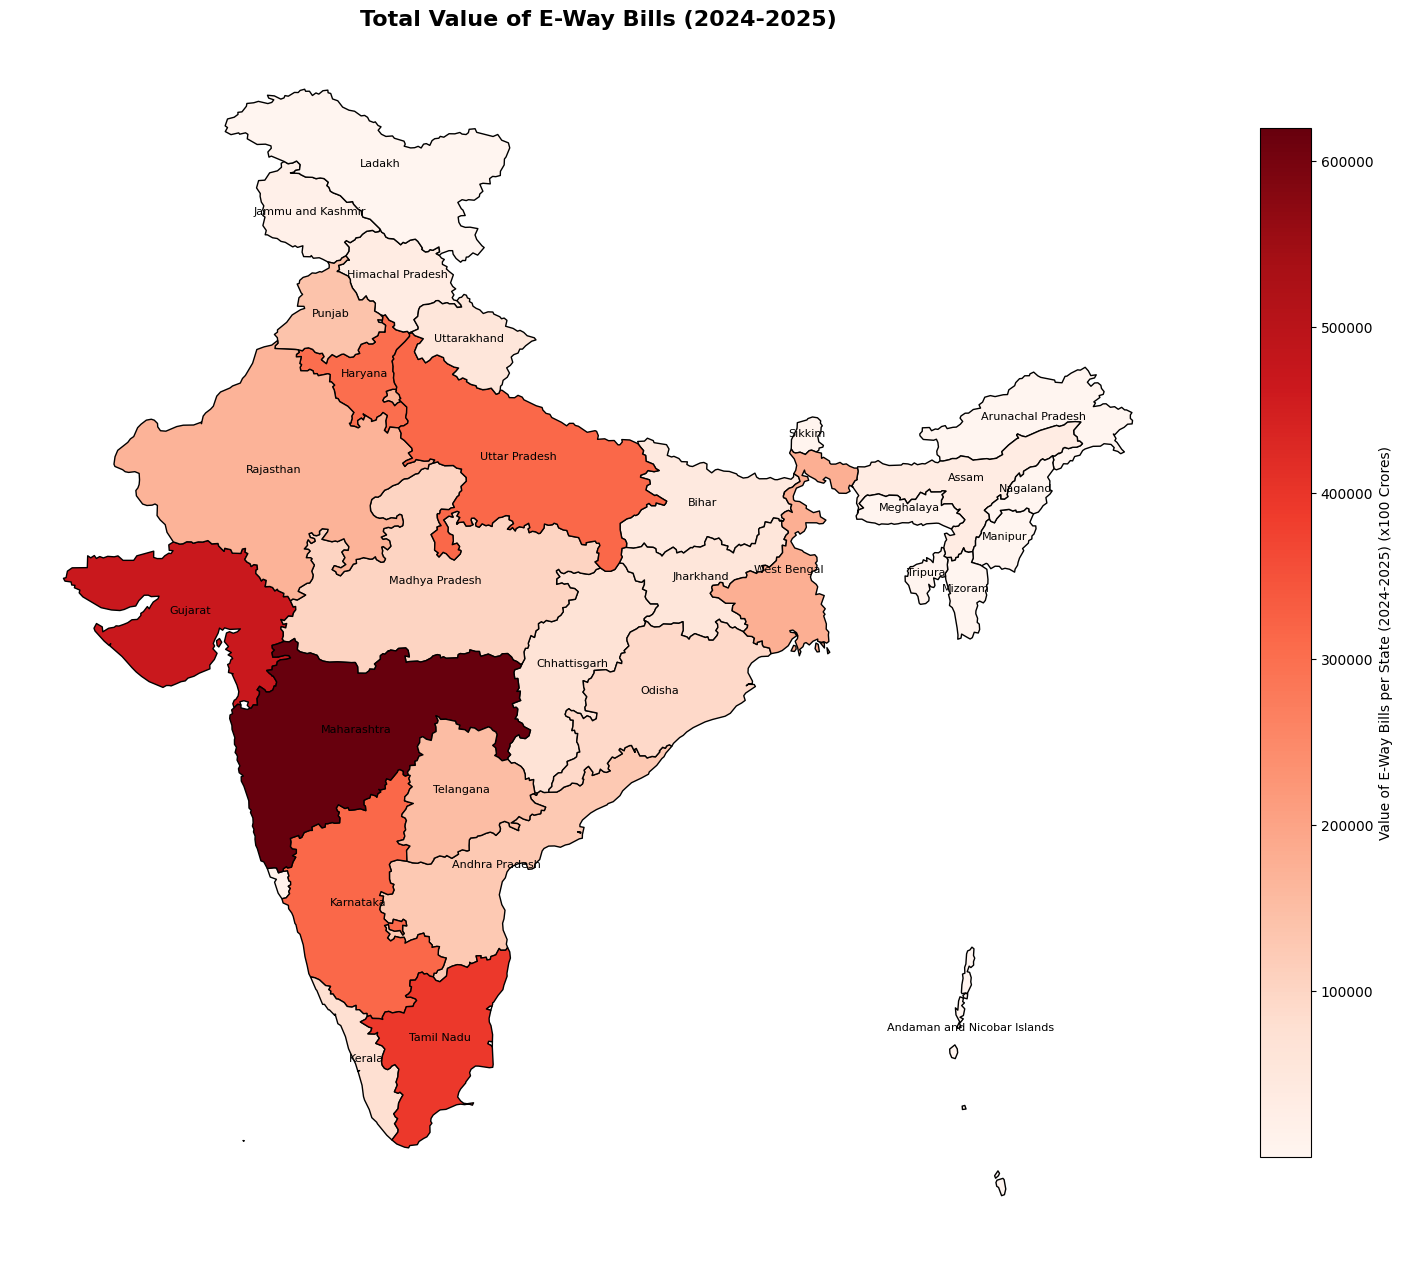

In [18]:
# Using the state mapping dictionary from above to match the names of the states and union territories
e_way_bill_value_total_df = e_way_bill_value_total_df.with_columns(
    st_nm_new = pl.col("state").replace(state_mapping)
).select(
    pl.col("st_nm_new"), 
    pl.col("value")
)

merged_pl = e_way_bill_value_total_df.join(
    gdf_pl, 
    left_on="st_nm_new", 
    right_on="st_nm", 
    how="inner"
).select(
    pl.col("st_nm_new").alias("st_nm"),
    pl.col("value"),
    pl.col("geometry")
)

merged_pandas = merged_pl.to_pandas()

# Reconstruct Geometry from WKT
merged_pandas['geometry'] = merged_pandas['geometry'].apply(wkt.loads)
merged_gdf = gpd.GeoDataFrame(merged_pandas, geometry='geometry')

merged_gdf = merged_gdf.dissolve(by='st_nm', aggfunc='first').reset_index()

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
merged_gdf.plot(column='value', 
                ax=ax, 
                legend=True,
                legend_kwds={
                    'label': "Value of E-Way Bills per State (2024-2025) (x100 Crores)", 
                    'orientation': 
                    "vertical", 
                    'shrink': 0.7
                },
                cmap='Reds', 
                edgecolor='black'
)

# Add Labels
for idx, row in merged_gdf.iterrows():
    if row.geometry.area > 0.5: 
        plt.annotate(text=row['st_nm'], 
                    xy=row.geometry.centroid.coords[0],
                    horizontalalignment='center', 
                    fontsize=8, 
                    color='black'
                    )

ax.set_title('Total Value of E-Way Bills (2024-2025)', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Mapping the E-Way Bill Values (2024-2025, Merchandise Trade Crossing State Boundaries)

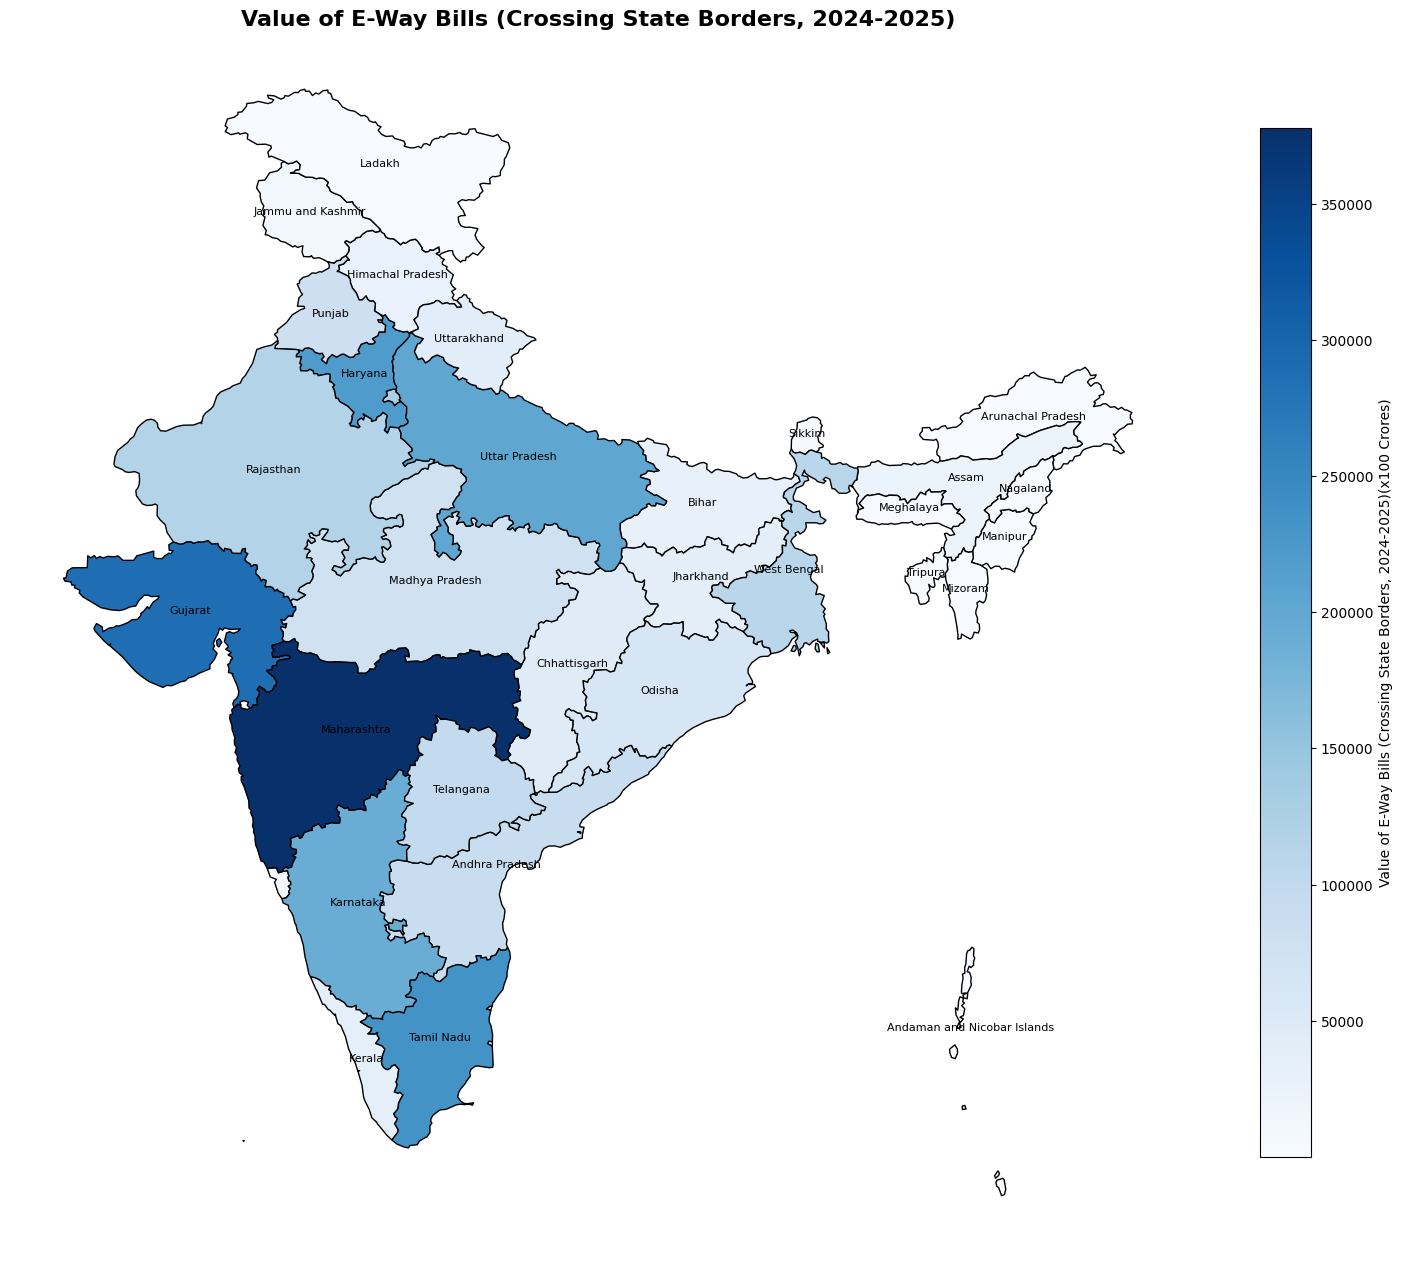

In [19]:
# Using the state mapping dictionary from above to match the names of the states and union territories
e_way_bill_value_external_df = e_way_bill_value_external_df.with_columns(
    st_nm_new = pl.col("state").replace(state_mapping)
).select(
    pl.col("st_nm_new"), 
    pl.col("value")
)

merged_pl = e_way_bill_value_external_df.join(
    gdf_pl, 
    left_on="st_nm_new", 
    right_on="st_nm", 
    how="inner"
).select(
    pl.col("st_nm_new").alias("st_nm"),
    pl.col("value"),
    pl.col("geometry")
)

merged_pandas = merged_pl.to_pandas()

# Reconstruct Geometry from WKT
merged_pandas['geometry'] = merged_pandas['geometry'].apply(wkt.loads)
merged_gdf = gpd.GeoDataFrame(merged_pandas, geometry='geometry')

merged_gdf = merged_gdf.dissolve(by='st_nm', aggfunc='first').reset_index()

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
merged_gdf.plot(column='value', 
                ax=ax, 
                legend=True,
                legend_kwds={
                    'label': "Value of E-Way Bills (Crossing State Borders, 2024-2025)(x100 Crores)", 
                    'orientation': 
                    "vertical", 
                    'shrink': 0.7
                },
                cmap='Blues', 
                edgecolor='black'
)

# Add Labels
for idx, row in merged_gdf.iterrows():
    if row.geometry.area > 0.5: 
        plt.annotate(text=row['st_nm'], 
                    xy=row.geometry.centroid.coords[0],
                    horizontalalignment='center', 
                    fontsize=8, 
                    color='black'
                    )

ax.set_title('Value of E-Way Bills (Crossing State Borders, 2024-2025)', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Mapping the E-Way Bill Values (2024-2025, Merchandise Trade inside State Boundaries)

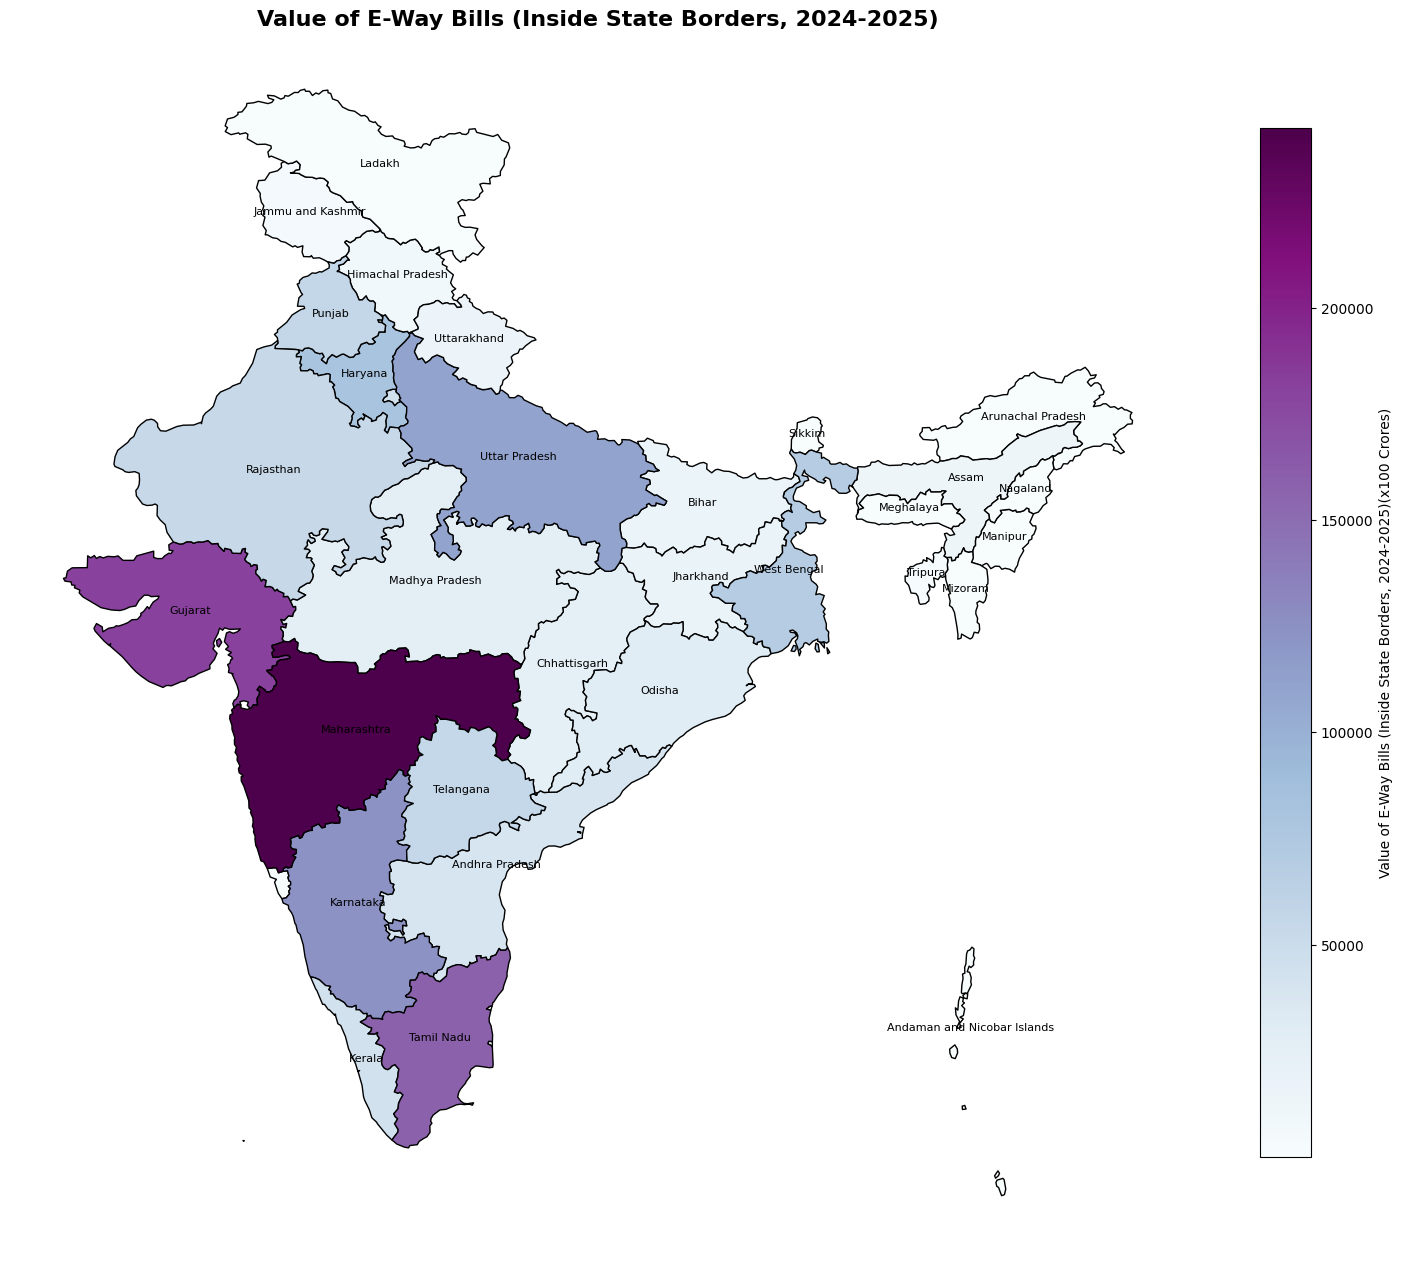

In [20]:
# Using the state mapping dictionary from above to match the names of the states and union territories
e_way_bill_value_internal_df = e_way_bill_value_internal_df.with_columns(
    st_nm_new = pl.col("state").replace(state_mapping)
).select(
    pl.col("st_nm_new"), 
    pl.col("value")
)

merged_pl = e_way_bill_value_internal_df.join(
    gdf_pl, 
    left_on="st_nm_new", 
    right_on="st_nm", 
    how="inner"
).select(
    pl.col("st_nm_new").alias("st_nm"),
    pl.col("value"),
    pl.col("geometry")
)

merged_pandas = merged_pl.to_pandas()

# Reconstruct Geometry from WKT
merged_pandas['geometry'] = merged_pandas['geometry'].apply(wkt.loads)
merged_gdf = gpd.GeoDataFrame(merged_pandas, geometry='geometry')

merged_gdf = merged_gdf.dissolve(by='st_nm', aggfunc='first').reset_index()

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
merged_gdf.plot(column='value', 
                ax=ax, 
                legend=True,
                legend_kwds={
                    'label': "Value of E-Way Bills (Inside State Borders, 2024-2025)(x100 Crores)", 
                    'orientation': 
                    "vertical", 
                    'shrink': 0.7
                },
                cmap='BuPu', 
                edgecolor='black'
)

# Add Labels
for idx, row in merged_gdf.iterrows():
    if row.geometry.area > 0.5: 
        plt.annotate(text=row['st_nm'], 
                    xy=row.geometry.centroid.coords[0],
                    horizontalalignment='center', 
                    fontsize=8, 
                    color='black'
                    )

ax.set_title('Value of E-Way Bills (Inside State Borders, 2024-2025)', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Mapping the CAGR of overall trade (2019-2025)

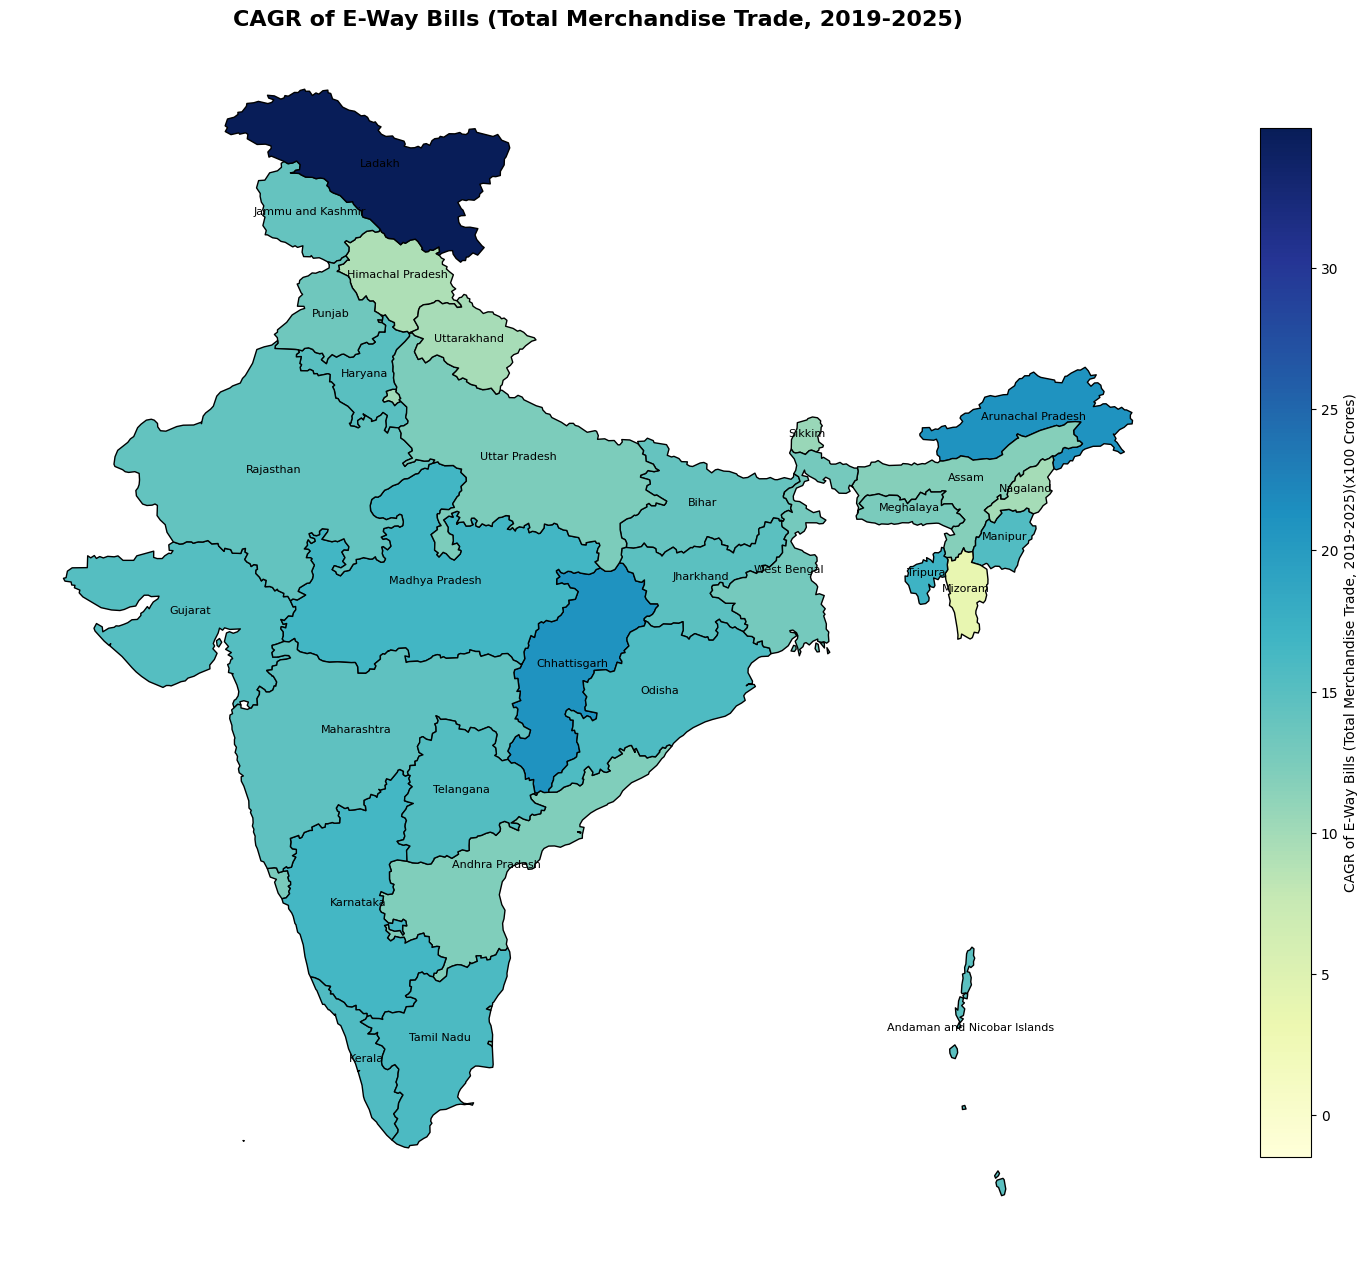

In [21]:
# Using the state mapping dictionary from above to match the names of the states and union territories
cagr_total_trade_value_df = cagr_total_trade_value_df.with_columns(
    st_nm_new = pl.col("state").replace(state_mapping)
).select(
    pl.col("st_nm_new"), 
    pl.col("value")
)

merged_pl = cagr_total_trade_value_df.join(
    gdf_pl, 
    left_on="st_nm_new", 
    right_on="st_nm", 
    how="inner"
).select(
    pl.col("st_nm_new").alias("st_nm"),
    pl.col("value"),
    pl.col("geometry")
)

merged_pandas = merged_pl.to_pandas()

# Reconstruct Geometry from WKT
merged_pandas['geometry'] = merged_pandas['geometry'].apply(wkt.loads)
merged_gdf = gpd.GeoDataFrame(merged_pandas, geometry='geometry')

merged_gdf = merged_gdf.dissolve(by='st_nm', aggfunc='first').reset_index()

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
merged_gdf.plot(column='value', 
                ax=ax, 
                legend=True,
                legend_kwds={
                    'label': "CAGR of E-Way Bills (Total Merchandise Trade, 2019-2025)(x100 Crores)", 
                    'orientation': 
                    "vertical", 
                    'shrink': 0.7
                },
                cmap='YlGnBu', 
                edgecolor='black'
)

# Add Labels
for idx, row in merged_gdf.iterrows():
    if row.geometry.area > 0.5: 
        plt.annotate(text=row['st_nm'], 
                    xy=row.geometry.centroid.coords[0],
                    horizontalalignment='center', 
                    fontsize=8, 
                    color='black'
                    )

ax.set_title('CAGR of E-Way Bills (Total Merchandise Trade, 2019-2025)', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Mapping the CAGR of Internal Merchandise Trade (2019-2025)

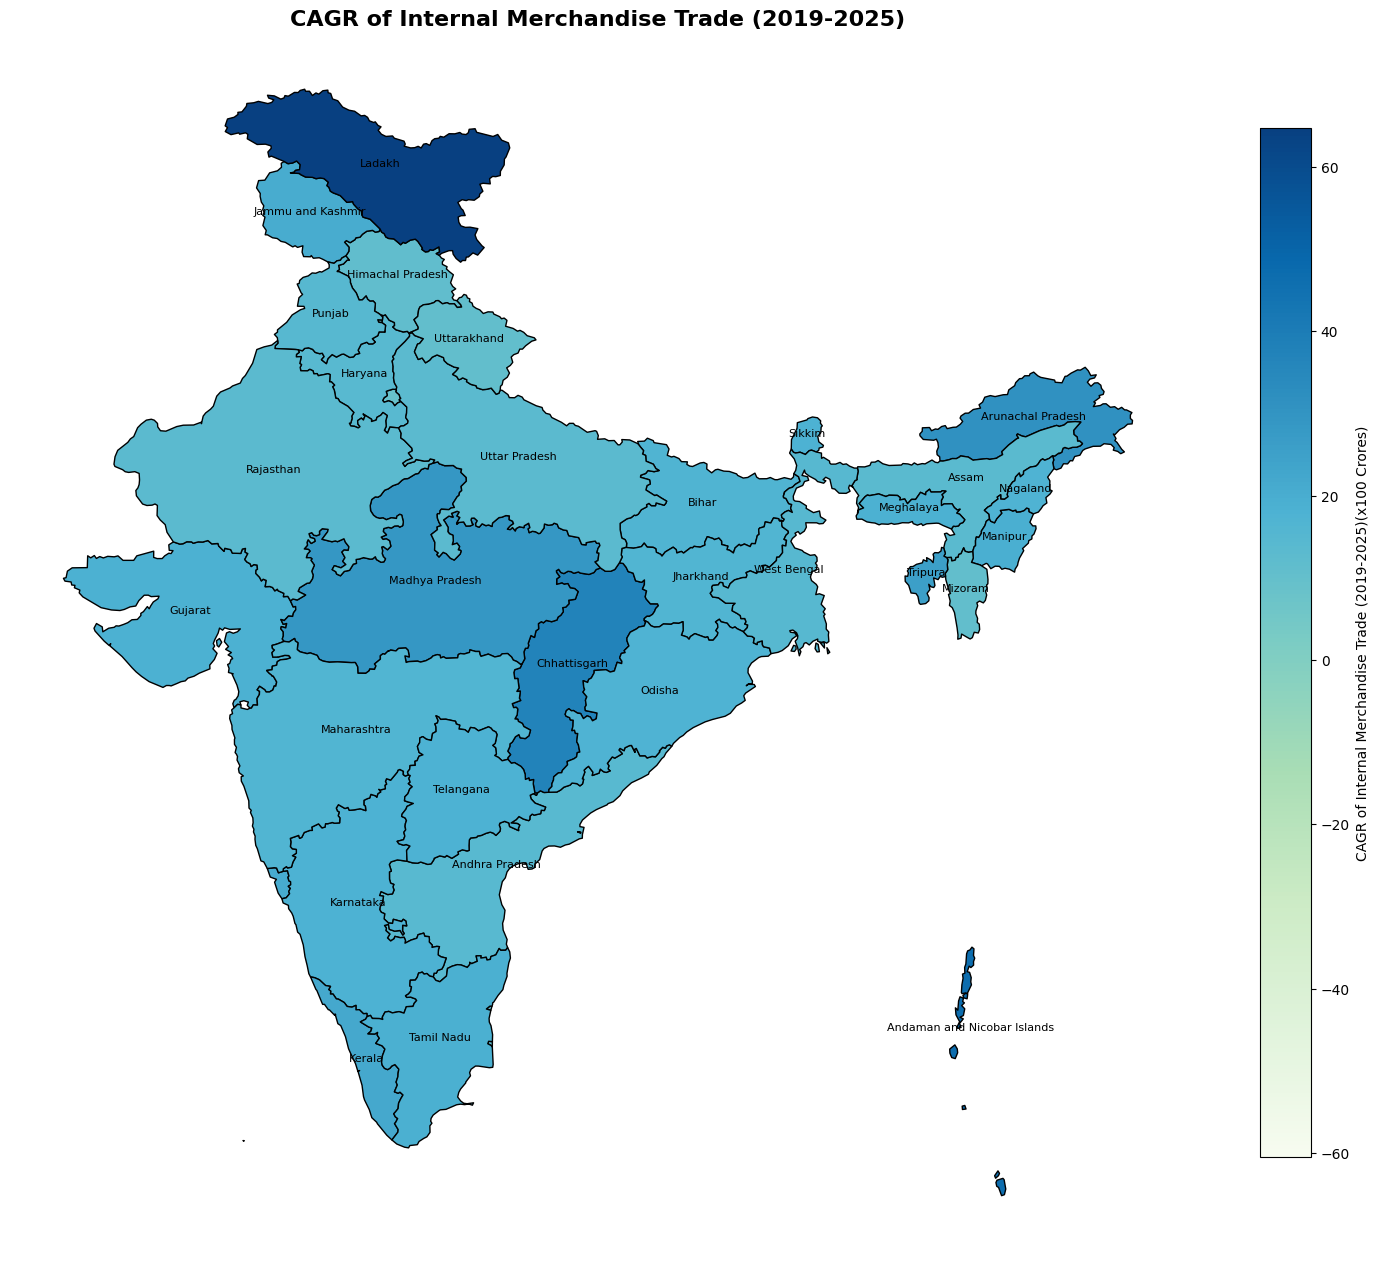

In [22]:
cagr_internal_trade_value_df = cagr_internal_trade_value_df.with_columns(
    st_nm_new = pl.col("state").replace(state_mapping)
).select(
    pl.col("st_nm_new"), 
    pl.col("value")
)

merged_pl = cagr_internal_trade_value_df.join(
    gdf_pl, 
    left_on="st_nm_new", 
    right_on="st_nm", 
    how="inner"
).select(
    pl.col("st_nm_new").alias("st_nm"),
    pl.col("value"),
    pl.col("geometry")
)

merged_pandas = merged_pl.to_pandas()

# Reconstruct Geometry from WKT
merged_pandas['geometry'] = merged_pandas['geometry'].apply(wkt.loads)
merged_gdf = gpd.GeoDataFrame(merged_pandas, geometry='geometry')

merged_gdf = merged_gdf.dissolve(by='st_nm', aggfunc='first').reset_index()

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
merged_gdf.plot(column='value', 
                ax=ax, 
                legend=True,
                legend_kwds={
                    'label': "CAGR of Internal Merchandise Trade (2019-2025)(x100 Crores)", 
                    'orientation': 
                    "vertical", 
                    'shrink': 0.7
                },
                cmap='GnBu', 
                edgecolor='black'
)

# Add Labels
for idx, row in merged_gdf.iterrows():
    if row.geometry.area > 0.5: 
        plt.annotate(text=row['st_nm'], 
                    xy=row.geometry.centroid.coords[0],
                    horizontalalignment='center', 
                    fontsize=8, 
                    color='black'
                    )

ax.set_title('CAGR of Internal Merchandise Trade (2019-2025)', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [23]:
# Generating plot for top 10 and bottom 10 states with Higest and Lowest CAGR in terms of value and count (Incoming Trade)
incoming_value_cagr = {}
incoming_count_cagr = {}

for state in indian_states:
    incoming_value_cagr[state] = all_state_stats[state][f"{state}_cagr_incoming_value"]
    incoming_count_cagr[state] = all_state_stats[state][f"{state}_cagr_incoming_count"]

incoming_value_cagr_decreasing = dict(sorted(incoming_value_cagr.items(), key=lambda item: item[1], reverse=True))
incoming_count_cagr_decreasing = dict(sorted(incoming_count_cagr.items(), key=lambda item: item[1], reverse=True))

incoming_value_cagr_top10 = list(incoming_value_cagr_decreasing.items())[:10]
incoming_count_cagr_top10 = list(incoming_count_cagr_decreasing.items())[:10]

incoming_value_cagr_bottom10 = list(incoming_value_cagr_decreasing.items())[-10:]
incoming_count_cagr_bottom10 = list(incoming_count_cagr_decreasing.items())[-10:]

# print(incoming_value_cagr_decreasing)
# print(incoming_value_cagr_top10)
# print(incoming_count_cagr_top10)

# print(incoming_value_cagr_bottom10)
# print(incoming_count_cagr_bottom10)


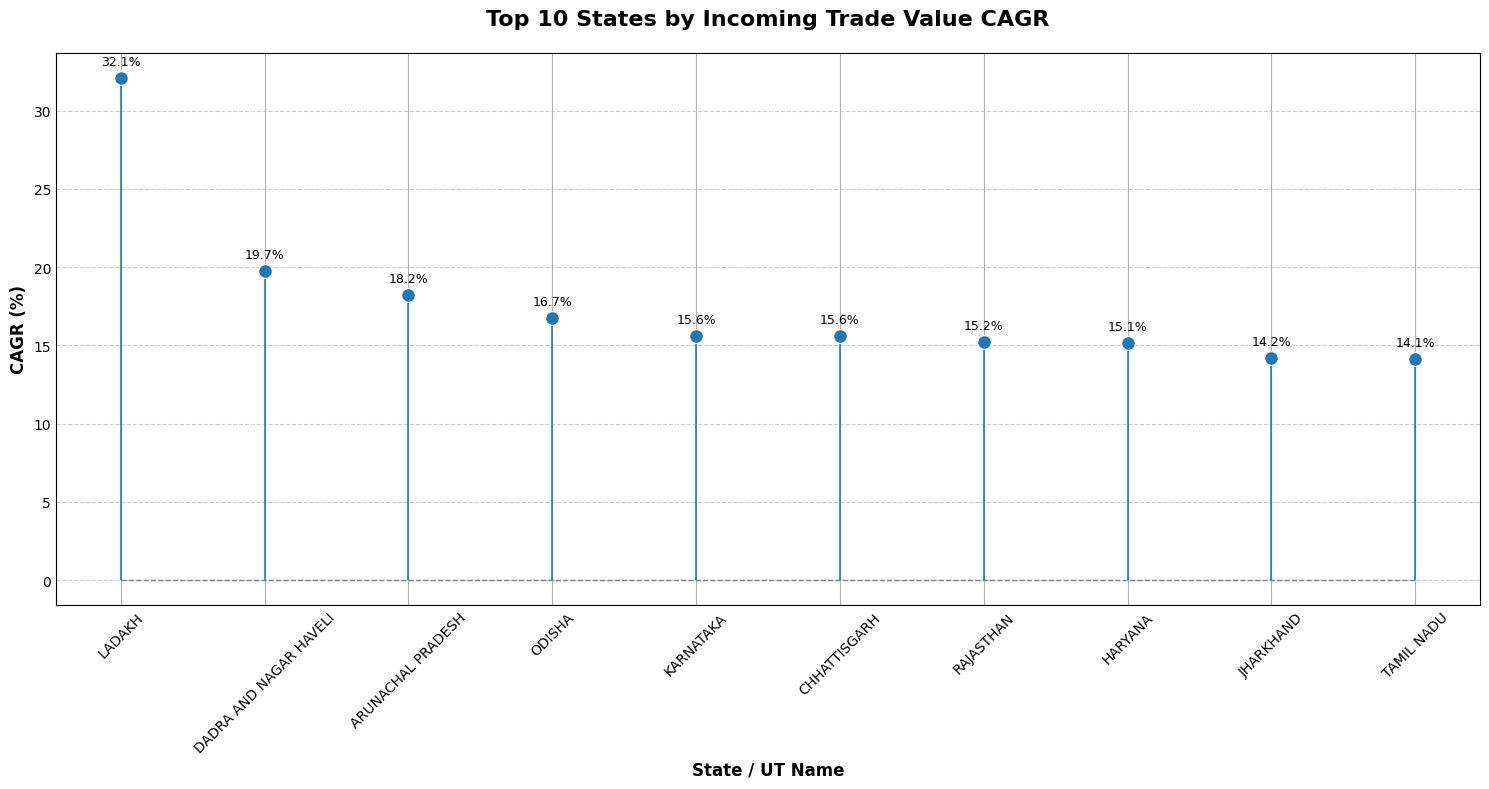

In [24]:
import numpy as np

plt.style.use('_mpl-gallery')

x = []
y = []
for item in incoming_value_cagr_top10:
    x.append(item[0])
    y.append(item[1])

fig, ax = plt.subplots(figsize=(15, 8))

markerline, stemlines, baseline = ax.stem(x, y)
plt.setp(markerline, marker='o', markersize=10, markeredgecolor='white', markeredgewidth=1)
plt.setp(stemlines, linestyle='-', linewidth=1.5, alpha=0.8)
plt.setp(baseline, color='gray', linewidth=1, linestyle='--')

ax.set_title('Top 10 States by Incoming Trade Value CAGR', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('CAGR (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('State / UT Name', fontsize=12, fontweight='bold')

ax.tick_params(axis='x', labelrotation=45, labelsize=10) # Tilt the X-Axis labels
ax.tick_params(axis='y', labelsize=10)

ax.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of markers
for i, v in enumerate(y):
    ax.text(i, v + (max(y)*0.02), f'{v:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()

plt.show()


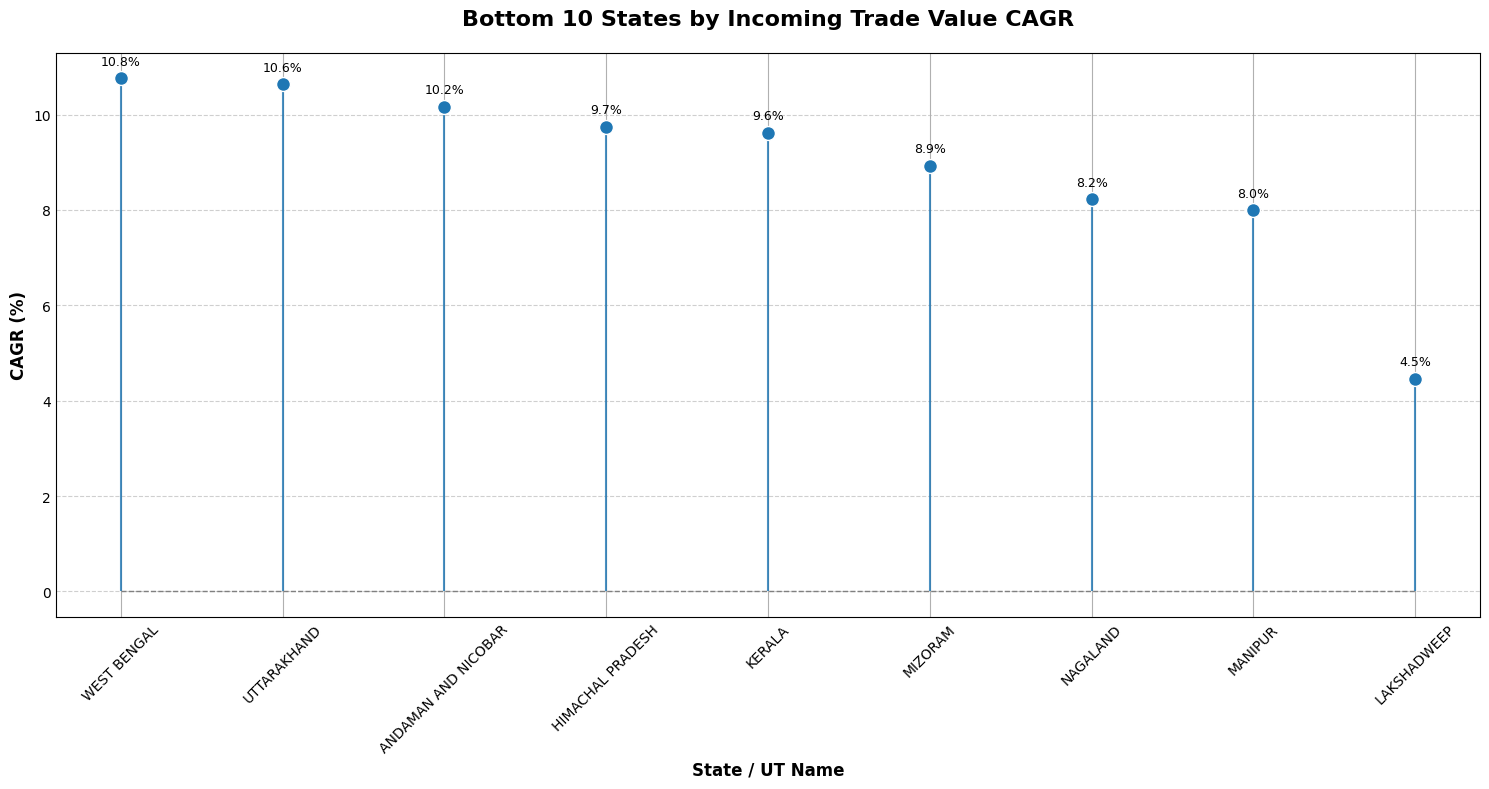

In [25]:
x = []
y = []
for item in incoming_value_cagr_bottom10:
    if item[0] == "DAMAN AND DIU": # Removing Daman and Diu from visualization as it got merged with Dadra and Nagar Haveli
        continue
    x.append(item[0])
    y.append(item[1])

fig, ax = plt.subplots(figsize=(15, 8))

markerline, stemlines, baseline = ax.stem(x, y)
plt.setp(markerline, marker='o', markersize=10, markeredgecolor='white', markeredgewidth=1)
plt.setp(stemlines, linestyle='-', linewidth=1.5, alpha=0.8)
plt.setp(baseline, color='gray', linewidth=1, linestyle='--')

ax.set_title('Bottom 10 States by Incoming Trade Value CAGR', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('CAGR (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('State / UT Name', fontsize=12, fontweight='bold')

ax.tick_params(axis='x', labelrotation=45, labelsize=10) # Tilt the X-Axis labels
ax.tick_params(axis='y', labelsize=10)

ax.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of markers
for i, v in enumerate(y):
    ax.text(i, v + (max(y)*0.02), f'{v:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()

plt.show()

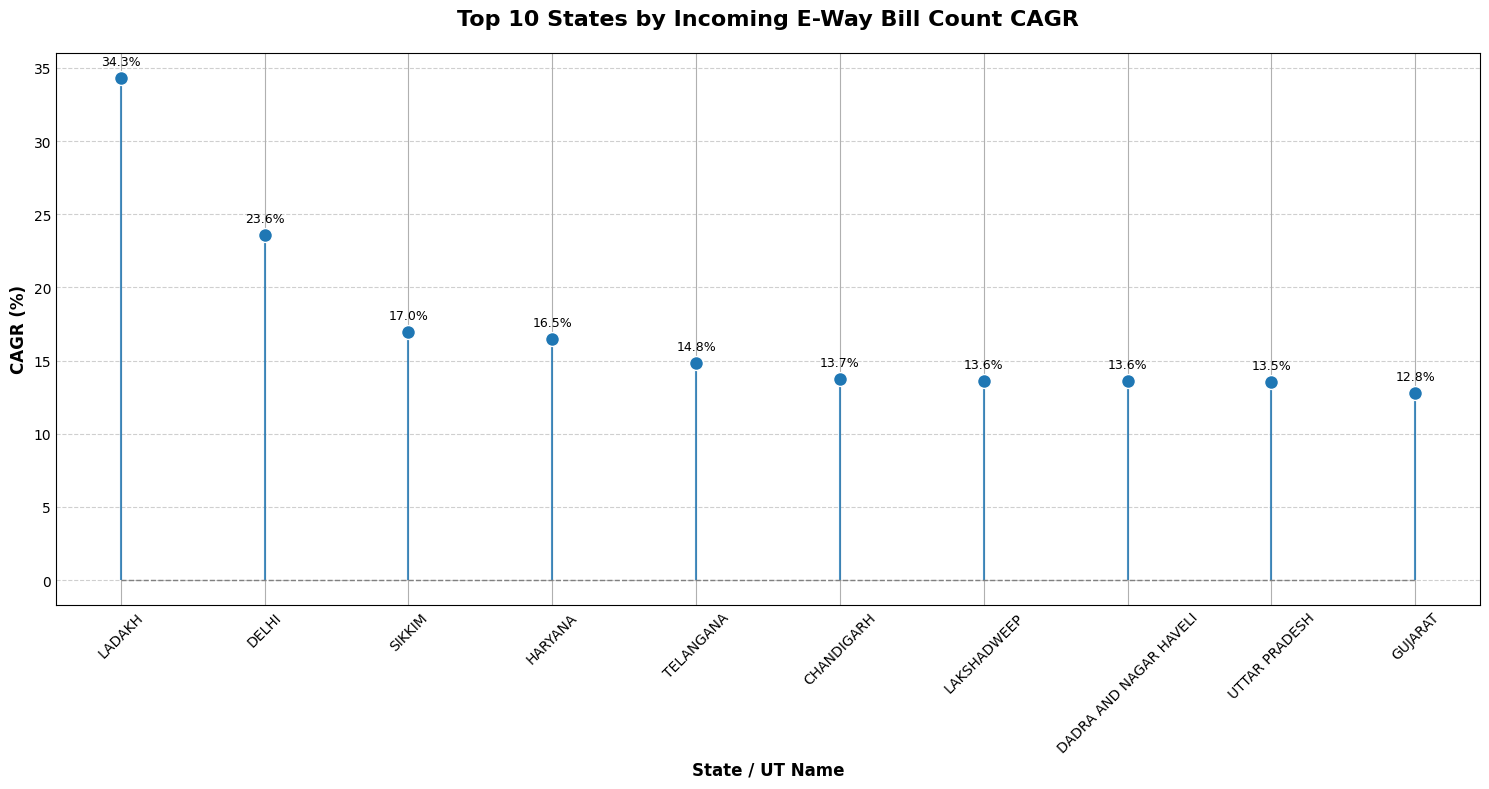

In [26]:
x = []
y = []
for item in incoming_count_cagr_top10:
    x.append(item[0])
    y.append(item[1])

fig, ax = plt.subplots(figsize=(15, 8))

markerline, stemlines, baseline = ax.stem(x, y)
plt.setp(markerline, marker='o', markersize=10, markeredgecolor='white', markeredgewidth=1)
plt.setp(stemlines, linestyle='-', linewidth=1.5, alpha=0.8)
plt.setp(baseline, color='gray', linewidth=1, linestyle='--')

ax.set_title('Top 10 States by Incoming E-Way Bill Count CAGR', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('CAGR (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('State / UT Name', fontsize=12, fontweight='bold')

ax.tick_params(axis='x', labelrotation=45, labelsize=10) # Tilt the X-Axis labels
ax.tick_params(axis='y', labelsize=10)

ax.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of markers
for i, v in enumerate(y):
    ax.text(i, v + (max(y)*0.02), f'{v:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()

plt.show()

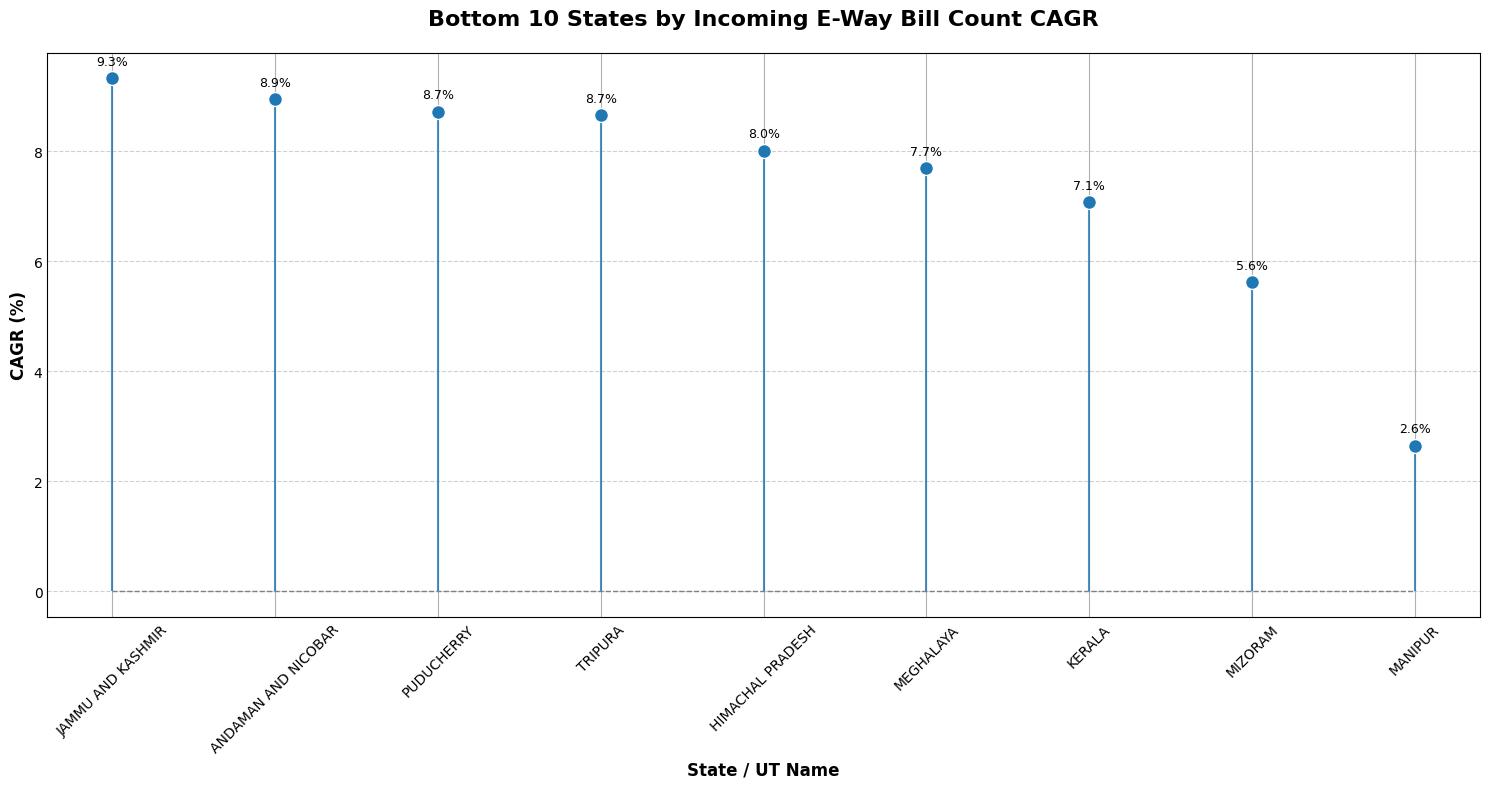

In [27]:
x = []
y = []
for item in incoming_count_cagr_bottom10:
    if item[0] == "DAMAN AND DIU": # Removing Daman and Diu from visualization as it got merged with Dadra and Nagar Haveli
        continue
    x.append(item[0])
    y.append(item[1])

fig, ax = plt.subplots(figsize=(15, 8))

markerline, stemlines, baseline = ax.stem(x, y)
plt.setp(markerline, marker='o', markersize=10, markeredgecolor='white', markeredgewidth=1)
plt.setp(stemlines, linestyle='-', linewidth=1.5, alpha=0.8)
plt.setp(baseline, color='gray', linewidth=1, linestyle='--')

ax.set_title('Bottom 10 States by Incoming E-Way Bill Count CAGR', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('CAGR (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('State / UT Name', fontsize=12, fontweight='bold')

ax.tick_params(axis='x', labelrotation=45, labelsize=10) # Tilt the X-Axis labels
ax.tick_params(axis='y', labelsize=10)

ax.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of markers
for i, v in enumerate(y):
    ax.text(i, v + (max(y)*0.02), f'{v:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()

plt.show()

In [28]:
# Generating plot for top 10 and bottom 10 states with Higest and Lowest CAGR in terms of value and count (Outgoing Trade)
outgoing_value_cagr = {}
outgoing_count_cagr = {}

for state in indian_states:
    outgoing_value_cagr[state] = all_state_stats[state][f"{state}_cagr_outgoing_value"]
    outgoing_count_cagr[state] = all_state_stats[state][f"{state}_cagr_outgoing_count"]

outgoing_value_cagr_decreasing = dict(sorted(outgoing_value_cagr.items(), key=lambda item: item[1], reverse=True))
outgoing_count_cagr_decreasing = dict(sorted(outgoing_count_cagr.items(), key=lambda item: item[1], reverse=True))

outgoing_value_cagr_top10 = list(outgoing_value_cagr_decreasing.items())[:10]
outgoing_count_cagr_top10 = list(outgoing_count_cagr_decreasing.items())[:10]

outgoing_value_cagr_bottom10 = list(outgoing_value_cagr_decreasing.items())[-10:]
outgoing_count_cagr_bottom10 = list(outgoing_count_cagr_decreasing.items())[-10:]

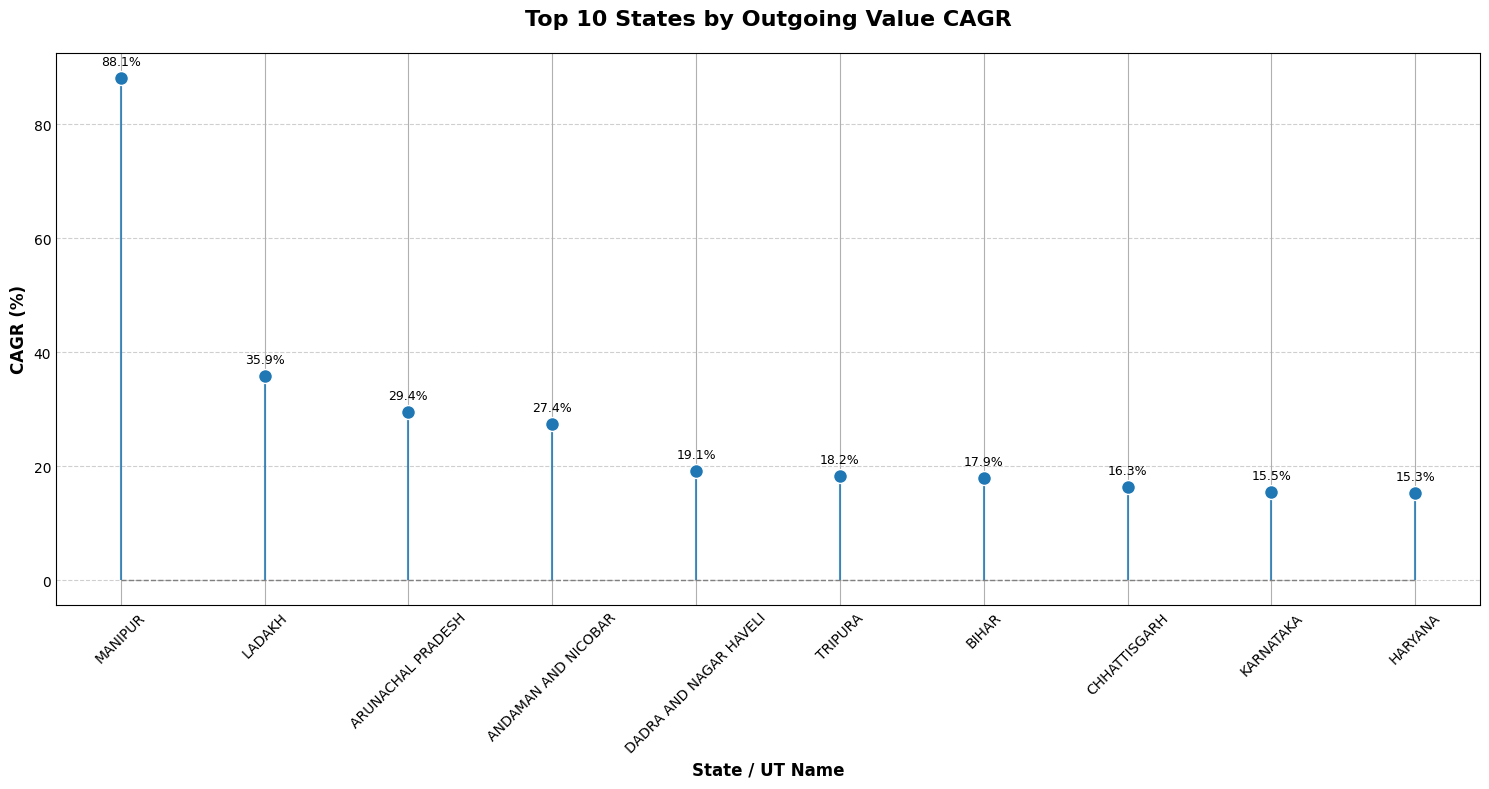

In [29]:
x = []
y = []
for item in outgoing_value_cagr_top10:
    x.append(item[0])
    y.append(item[1])

fig, ax = plt.subplots(figsize=(15, 8))

markerline, stemlines, baseline = ax.stem(x, y)
plt.setp(markerline, marker='o', markersize=10, markeredgecolor='white', markeredgewidth=1)
plt.setp(stemlines, linestyle='-', linewidth=1.5, alpha=0.8)
plt.setp(baseline, color='gray', linewidth=1, linestyle='--')

ax.set_title('Top 10 States by Outgoing Value CAGR', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('CAGR (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('State / UT Name', fontsize=12, fontweight='bold')

ax.tick_params(axis='x', labelrotation=45, labelsize=10) # Tilt the X-Axis labels
ax.tick_params(axis='y', labelsize=10)

ax.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of markers
for i, v in enumerate(y):
    ax.text(i, v + (max(y)*0.02), f'{v:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()

plt.show()

In [30]:
# Showing Plot for the Bottom 10 states and UT's with Lowest CAGR (Incoming Trade)

In [31]:
# Plot of Top 10 States with highest outgoing trade CAGR

In [32]:
# Plot of Bottom 10 States with lowest outgoing trade CAGR

In [33]:
# Plot of Top 10 states with highest CAGR in internal trade

In [34]:
# Plot of Bottom 10 states with lowest CAGR in internal trade

In [35]:
# Now I will try to find the states that have the lowest correlation between incoming and outgoing trade
# Then I will also find the states that have the lowest and highest correlation between internal and external trade

incoming_outgoing_correlation = {}

for state in indian_states:
    incoming_outgoing_correlation[state] = all_state_stats[state][f"{state}_correlation_bw_incoming_outgoing_trade"]

most_correlated_incoming_outgoing = sorted(incoming_outgoing_correlation.items(), key=lambda item: item[1], reverse=True)[:10]
# print(most_correlated_incoming_outgoing)

least_correlated_incoming_outgoing = sorted(incoming_outgoing_correlation.items(), key=lambda item: item[1])[:10]
# print(least_correlated_incoming_outgoing)

within_external_correlation = {}

for state in indian_states:
    within_external_correlation[state] = all_state_stats[state][f"{state}_correlation_bw_external_trade_and_within_trade"]
    # print(most_correlated_within_external)


most_correlated_within_external = sorted(within_external_correlation.items(), key=lambda item: item[1], reverse=True)[:10]
# print(most_correlated_within_external)

least_correlated_within_external = sorted(within_external_correlation.items(), key=lambda item: item[1])[:10]
# print(least_correlated_within_external)




In [36]:
print("States with highest correlation between incoming and outgoing trade value")
print("\n")
print("Note: A large posistive number near 1 indicates that Value of Incoming and Outgoing Trade is changing at the same rate")
print("\n")
for item in most_correlated_incoming_outgoing:
    print(item[0], item[1])


States with highest correlation between incoming and outgoing trade value


Note: A large posistive number near 1 indicates that Value of Incoming and Outgoing Trade is changing at the same rate


DADRA AND NAGAR HAVELI 0.9919191088870557
HARYANA 0.9916089280912742
PUNJAB 0.9819435156171231
UTTAR PRADESH 0.9800125383058129
PUDUCHERRY 0.9799114641204543
CHANDIGARH 0.9797903362622452
GUJARAT 0.9795376034853491
RAJASTHAN 0.9774893525139416
MAHARASHTRA 0.9767932412927025
HIMACHAL PRADESH 0.9760625640209041


In [37]:
print("States with lowest correlation between incoming and outgoing trade value")
print("\n")
print("Note: A negative number near -1 (or >0) indicates that Value of Outgoing Trade is decreasing compared to Value of Incoming Trade")
print("\n")
for item in least_correlated_incoming_outgoing:
    print(item[0], item[1])

States with lowest correlation between incoming and outgoing trade value


Note: A negative number near -1 (or >0) indicates that Value of Outgoing Trade is decreasing compared to Value of Incoming Trade


MIZORAM -0.32456444991540895
Other Territory -0.03903873549302506
LAKSHADWEEP 0.2226120008719467
MANIPUR 0.4099518417923065
GOA 0.5855707601914412
LADAKH 0.7034739053366471
ANDAMAN AND NICOBAR 0.7245962973494714
NAGALAND 0.7863292744209195
ARUNACHAL PRADESH 0.7913803674660393
JHARKHAND 0.8148975850835464


In [ ]:
def plot_state_analysis(State):
    results = all_state_stats[State]
    fig, axes = plt.subplots(4, 1, figsize=(12, 18))

    plot_types = [
        (f"{State}_incoming", "Incoming Trade"),
        (f"{State}_outgoing", "Outgoing Trade"),
        (f"{State}_within",   "Within State Trade")
    ]
    
    for i, (key, title) in enumerate(plot_types):
        df = results[key]
        ax1 = axes[i]
        
        color_count = 'tab:red'
        
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('Count of E-Way Bills', color=color_count, fontsize=12, fontweight='bold')

        ax1.plot(df['Formatted_Date'], df['Count of E-Way Bills'], 
                 color=color_count, marker='o', linestyle='-', linewidth=2)
        ax1.tick_params(axis='y', labelcolor=color_count)
        ax1.grid(True, alpha=0.3)
        
        ax2 = ax1.twinx()
        color_val = 'tab:blue'

        ax2.set_ylabel('Value of E-Way Bills (INR)', color=color_val, fontsize=12, fontweight='bold')
        
        ax2.plot(df['Formatted_Date'], df['Value of E-Way Bills'], 
                 color=color_val, marker='x', linestyle='--', linewidth=2)
        ax2.tick_params(axis='y', labelcolor=color_val)
        
        ax1.set_title(f"{title} - {State}", fontsize=16, pad=15)

    ax_text = axes[3]
    ax_text.axis('off') 

    """================================================================================================="""
    """------Text Section: Domestic Inter-State Trade Analysis (Excludes Direct Int'l Trade)-----------"""
    """================================================================================================="""
    
    # 1. Incoming vs Outgoing (Domestic Integration)
    # Context: "Incoming" = Buying from India. "Outgoing" = Selling to India.
    corr_incoming_outgoing = all_state_stats[State][f"{State}_correlation_bw_incoming_outgoing_trade"]
    
    if (corr_incoming_outgoing < correlation_info_incoming_outgoing['p25']):
        comment_on_correlation_incoming_outgoing = "Structurally Decoupled (Domestic).\n   - The state's buying and selling patterns with the rest of India are mismatched.\n   - Could indicate a 'Gateway State' (Imports internationally -> Sells to India) or a 'Pure Consumer' (Buys from India -> Consumes locally)."
    elif (corr_incoming_outgoing < correlation_info_incoming_outgoing['avg']):
        comment_on_correlation_incoming_outgoing = "Weak Domestic Coupling.\n   - The state's economy operates on different cycles compared to the national supply chain."
    elif (corr_incoming_outgoing < correlation_info_incoming_outgoing['p75']):
        comment_on_correlation_incoming_outgoing = "Integrated National Hub.\n   - Strong link between what the state buys from India and what it sells back to India.\n   - Indicates a 'Processing' economy (e.g., buying raw materials from State A, selling finished goods to State B)."
    else:
        comment_on_correlation_incoming_outgoing = "Highly Synchronized National Trade.\n   - The state is a critical node in the domestic grid; changes in national demand are immediately reflected in both its inward and outward flows."


    # 2. External vs Internal (Domestic Logistics)
    # Context: External = Trade with other States. Internal = Trade within the State.
    corr_internal_external = all_state_stats[State][f"{State}_correlation_bw_external_trade_and_within_trade"]
    
    if (corr_internal_external < correlation_info_internal_external['p25']):
        comment_on_correlation_internal_external = "Transit State or Import-Heavy Retail.\n    - Goods enter from other states but don't trigger proportional internal movements (likely breaking bulk <50k).\n    - Alternatively, the state acts as a corridor for trucks passing through to neighbors."
    elif (corr_internal_external < correlation_info_internal_external['avg']):
        comment_on_correlation_internal_external = "Uneven Logistics Depth.\n    - Growth in trade with other states hasn't fully trickled down to the organized local logistics network."
    elif (corr_internal_external < correlation_info_internal_external['p75']):
        comment_on_correlation_internal_external = "Mature Domestic Distribution.\n    - High alignment suggests that goods bought from other states are efficiently distributed locally via the organized sector."
    else:
        comment_on_correlation_internal_external = "Fully Integrated Logistics Grid.\n   - Every surge in Inter-State trade triggers an immediate, proportional surge in Intra-State movement."


    # 3. Value vs Count (Incoming from India)
    # Context: Volatility in the "Price per Truck" coming from other states.
    corr_value_count_incoming = all_state_stats[State][f"{State}_correlation_bw_count_and_value_incoming"]
    
    if (corr_value_count_incoming < correlation_value_count_incoming['p25']):
        comment_on_correlation_value_count_incoming = "High Volatility (Domestic Inputs).\n    - The value of goods bought from other states fluctuates heavily (e.g., seasonal agriculture, fuel, or varied industrial components)."
    elif (corr_value_count_incoming < correlation_value_count_incoming['avg']):
        comment_on_correlation_value_count_incoming = "Mixed Input Basket.\n    - The state sources a complex mix of high-value and low-value goods from the rest of India."
    elif (corr_value_count_incoming < correlation_value_count_incoming['p75']):
        comment_on_correlation_value_count_incoming = "Standardized Domestic Inputs.\n    - The basket of goods purchased from other states is stable (Volume predicts Value reliably)."
    else:
        comment_on_correlation_value_count_incoming = "Highly Predictable Inflow.\n   - Very stable pricing in inter-state purchases; likely bulk standardized commodities."

    
    # 4. Value vs Count (Outgoing to India)
    # Context: Volatility in the "Price per Truck" sold to other states.
    corr_value_count_outgoing = all_state_stats[State][f"{State}_correlation_bw_count_and_value_outgoing"]
    
    if (corr_value_count_outgoing < correlation_value_count_outgoing['p25']):
        comment_on_correlation_value_count_outgoing = "Volatile Domestic Exports.\n    - The value sold to other states is highly sensitive to price changes (e.g., selling crop yields or raw minerals to neighbors)."
    elif (corr_value_count_outgoing < correlation_value_count_outgoing['avg']):
        comment_on_correlation_value_count_outgoing = "Variable Output Value.\n    - The state sells a diverse mix of goods to the national market, causing fluctuations in average bill value."
    elif (corr_value_count_outgoing < correlation_value_count_outgoing['p75']):
        comment_on_correlation_value_count_outgoing = "Manufacturing-Led Supply.\n    - High correlation implies the state sells finished/standardized goods to India (Stable pricing)."
    else:
        comment_on_correlation_value_count_outgoing = "Highly Standardized Outflow.\n   - Revenue from other states is strictly volume-dependent (e.g., Cement, Steel, FMCG)."


    # 5. Value vs Count (Internal/Within)
    # Context: Local Trade Structure.
    corr_value_count_internal = all_state_stats[State][f"{State}_correlation_bw_count_and_value_within"]
    
    if (corr_value_count_internal < correlation_value_count_within['p25']):
        comment_on_correlation_value_count_internal = "Informal/Fragmented Local Market.\n    - Internal trade is volatile; significant variance in the value of goods moved locally."
    elif (corr_value_count_internal < correlation_value_count_within['avg']):
        comment_on_correlation_value_count_internal = "Developing Internal Market.\n    - Moderate link between local trip volume and economic value."
    elif (corr_value_count_internal < correlation_value_count_within['p75']):
        comment_on_correlation_value_count_internal = "Organized Local Supply Chain.\n    - Internal movements are standardized (likely organized Retail/FMCG distribution)."
    else:
        comment_on_correlation_value_count_internal = "Highly Mature Local Market.\n   - Strong linear relationship indicates a formalized, efficient internal logistics sector."


    # corr_incoming_outgoing = all_state_stats[State][f"{State}_correlation_bw_incoming_outgoing_trade"]
    # if (corr_incoming_outgoing < correlation_info_incoming_outgoing['p25']):
    #     comment_on_correlation_incoming_outgoing = "In the Bottom Quartile of States. \n   - Indicates that state is turning into a net importer or exporter. \n    - Potentially unhealthy if continues for several years"
    # elif (corr_incoming_outgoing < correlation_info_incoming_outgoing['avg']):
    #     comment_on_correlation_incoming_outgoing = "In the Bottom Half of States. \n   - Indicates that state is turning into a net importer or exporter. \n    - Potentially unhealthy if continues for several years"
    # elif (corr_incoming_outgoing < correlation_info_incoming_outgoing['p75']):
    #     comment_on_correlation_incoming_outgoing = "In the Top Half of States. \n   Imports and Exports being positively correlated is one sign of rising economic health"
    # else:
    #     comment_on_correlation_incoming_outgoing = "In the top quartile of States. \n   Imports and Exports being positively correlated is one sign of rising economic health"


    # corr_internal_external = all_state_stats[State][f"{State}_correlation_bw_external_trade_and_within_trade"]
    # if (corr_internal_external < correlation_info_internal_external['p25']):
    #     comment_on_correlation_internal_external = "In the Bottom Quartile of States. \n    - Mismatch over the long run will cause state to lose competitiveness (if weaker external activity) or export dependence (over-reliance on internal activity)"
    # elif (corr_internal_external < correlation_info_internal_external['avg']):
    #     comment_on_correlation_internal_external = "In the Bottom Half of States. \n    - Mismatch over the long run will cause state to lose competitiveness (if weaker external activity) or export dependence (over-reliance on internal activity)"
    # elif (corr_internal_external < correlation_info_internal_external['p75']):
    #     comment_on_correlation_internal_external = "In the Top Half of States. \n    - Alignment of External and Internal Activity is considered healthy over the long-term"
    # else:
    #     comment_on_correlation_internal_external = "In the top quartile of States. \n   - Alignment of External and Internal Activity is considered healthy over the long-term"

    # corr_value_count_incoming = all_state_stats[State][f"{State}_correlation_bw_count_and_value_incoming"]
    # if (corr_value_count_incoming < correlation_value_count_incoming['p25']):
    #     comment_on_correlation_value_count_incoming = "In the Bottom Quartile of States. \n    - The average bill size (value per bill) is much more volatile compared to other states"
    # elif (corr_value_count_incoming < correlation_value_count_incoming['avg']):
    #     comment_on_correlation_value_count_incoming = "In the Bottom Half of States. \n    - The average bill size (value per bill) is more volatile compared to other states"
    # elif (corr_value_count_incoming < correlation_value_count_incoming['p75']):
    #     comment_on_correlation_value_count_incoming = "In the Top Half of States. \n    - The average bill size (value per bill) is less volatile compared to other states"
    # else:
    #     comment_on_correlation_value_count_incoming = "In the top quartile of States. \n   - The average bill size (value per bill) is far less volatile compared to other states"

    # corr_value_count_outgoing = all_state_stats[State][f"{State}_correlation_bw_count_and_value_outgoing"]
    # if (corr_value_count_outgoing < correlation_value_count_outgoing['p25']):
    #     comment_on_correlation_value_count_outgoing = "In the Bottom Quartile of States. \n    - The average bill size (value per bill) is much more volatile compared to other states"
    # elif (corr_value_count_outgoing < correlation_value_count_outgoing['avg']):
    #     comment_on_correlation_value_count_outgoing = "In the Bottom Half of States. \n    - The average bill size (value per bill) is more volatile compared to other states"
    # elif (corr_value_count_outgoing < correlation_value_count_outgoing['p75']):
    #     comment_on_correlation_value_count_outgoing = "In the Top Half of States. \n    - The average bill size (value per bill) is less volatile compared to other states"
    # else:
    #     comment_on_correlation_value_count_outgoing = "In the top quartile of States. \n   - The average bill size (value per bill) is far less volatile compared to other states"

    # corr_value_count_internal = all_state_stats[State][f"{State}_correlation_bw_count_and_value_within"]
    # if (corr_value_count_internal < correlation_value_count_within['p25']):
    #     comment_on_correlation_value_count_internal = "In the Bottom Quartile of States. \n    - The average bill size (value per bill) is much more volatile compared to other states"
    # elif (corr_value_count_internal < correlation_value_count_within['avg']):
    #     comment_on_correlation_value_count_internal = "In the Bottom Half of States. \n    - The average bill size (value per bill) is more volatile compared to other states"
    # elif (corr_value_count_internal < correlation_value_count_within['p75']):
    #     comment_on_correlation_value_count_internal = "In the Top Half of States. \n    - The average bill size (value per bill) is less volatile compared to other states"
    # else:
    #     comment_on_correlation_value_count_internal = "In the top quartile of States. \n   - The average bill size (value per bill) is far less volatile compared to other states"

    """================================================================================================="""
    """ ---------------------- Rendering the Generated Text in this Function Below----------------------"""
    """================================================================================================="""


    analysis_text = f"""Analysis for {State}:

    1. Correlation between Incoming and Outgoing Trade (Crosses State Borders): {corr_incoming_outgoing: .4f}
    - Average Correlation: {correlation_info_incoming_outgoing['avg']: .4f}, 25th Percentile: {correlation_info_incoming_outgoing['p25']: .4f}, 75th Percentile: {correlation_info_incoming_outgoing['p75']: .4f}
    - {comment_on_correlation_incoming_outgoing}
    
    2. Correlation between Internal and External Trade: {corr_internal_external: .4f}
    - Average Correlation: {correlation_info_internal_external['avg']: .4f}, 25th Percentile: {correlation_info_internal_external['p25']: .4f}, 75th Percentile: {correlation_info_internal_external['p75']: .4f}
    - {comment_on_correlation_internal_external}
    
    3. Correlation between Count and Value of Trade (Incoming): {corr_value_count_internal: .4f}
    - Average Correlation: {correlation_value_count_incoming['avg']: .4f}, 25th Percentile: {correlation_value_count_incoming['p25']: .4f}, 75th Percentile: {correlation_value_count_incoming['p75']: .4f}
    - {comment_on_correlation_value_count_incoming}
    
    4. Correlation between Count and Value of Trade (Outgoing): {corr_value_count_outgoing: .4f}
    - Average Correlation: {correlation_value_count_outgoing['avg']: .4f}, 25th Percentile: {correlation_value_count_outgoing['p25']: .4f}, 75th Percentile: {correlation_value_count_outgoing['p75']: .4f}
    - {comment_on_correlation_value_count_outgoing}
    
    5. Correlation between Count and Value of Trade (Internal): {corr_value_count_internal: .4f}
    - Average Correlation: {correlation_value_count_within['avg']: .4f}, 25th Percentile: {correlation_value_count_within['p25']: .4f}, 75th Percentile: {correlation_value_count_within['p75']: .4f}
    - {comment_on_correlation_value_count_internal}
    
    """
    
    ax_text.text(0.0, 1.0, analysis_text, 
                 fontsize=10, 
                 verticalalignment='top', 
                 horizontalalignment='left',
                 linespacing=1.8)

    plt.tight_layout()
    plt.show()


interact(plot_state_analysis, State=indian_states);

interactive(children=(Dropdown(description='State', options=('ANDAMAN AND NICOBAR', 'ANDHRA PRADESH', 'ARUNACH…

In [39]:
employment_data = pl.read_csv("Datasets/India_Employment.csv")
employment_data.head(5)

shape: (5, 7)
┌─────────┬─────────────┬────────┬────────────┬──────────────┬───────────────┬─────────────────┐
│ Country ┆ Year        ┆ Gender ┆ State Name ┆ Type Of Area ┆ Status Of     ┆ Percentage      │
│ ---     ┆ ---         ┆ ---    ┆ ---        ┆ ---          ┆ Employment    ┆ Distribution Of │
│ str     ┆ str         ┆ str    ┆ str        ┆ str          ┆ ---           ┆ Wor…            │
│         ┆             ┆        ┆            ┆              ┆ str           ┆ ---             │
│         ┆             ┆        ┆            ┆              ┆               ┆ f64             │
╞═════════╪═════════════╪════════╪════════════╪══════════════╪═══════════════╪═════════════════╡
│ India   ┆ Agriculture ┆ Female ┆ All India  ┆ Rural        ┆ All self      ┆ 73.5            │
│         ┆ Year (Jul - ┆        ┆            ┆              ┆ employed      ┆                 │
│         ┆ Jun), …     ┆        ┆            ┆              ┆               ┆                 │
│ India   ┆ Agriculture ┆ Female ┆ All India  ┆ Rural        ┆ Casual labour ┆ 18.7            │
│         ┆ Year (Jul - ┆        ┆            ┆              ┆               ┆                 │
│         ┆ Jun), …     ┆        ┆            ┆              ┆               ┆                 │
│ India   ┆ Agriculture ┆ Female ┆ All India  ┆ Rural        ┆ Regular       ┆ 7.8             │
│         ┆ Year (Jul - ┆        ┆            ┆              ┆ wage/salary   ┆                 │
│         ┆ Jun), …     ┆        ┆            ┆              ┆               ┆                 │
│ India   ┆ Agriculture ┆ Female ┆ All India  ┆ Rural        ┆ Self-Employed ┆ 42.3            │
│         ┆ Year (Jul - ┆        ┆            ┆              ┆ helper in     ┆                 │
│         ┆ Jun), …     ┆        ┆            ┆              ┆ hourse…       ┆                 │
│ India   ┆ Agriculture ┆ Female ┆ All India  ┆ Rural        ┆ Self-Employed ┆ 31.2            │
│         ┆ Year (Jul - ┆        ┆            ┆              ┆ own account   ┆                 │
│         ┆ Jun), …     ┆        ┆            ┆              ┆ work…         ┆                 │
└─────────┴─────────────┴────────┴────────────┴──────────────┴───────────────┴─────────────────┘

In [40]:
# Find types of employment
employment_types = employment_data.select(
    pl.col("Status Of Employment").unique()
)
print(employment_types)

shape: (6, 1)
┌─────────────────────────────────┐
│ Status Of Employment            │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ Self-Employed own account work… │
│ Casual labour                   │
│ all                             │
│ All self employed               │
│ Regular wage/salary             │
│ Self-Employed helper in hourse… │
└─────────────────────────────────┘


In [41]:
# Find unique years in the data
unique_years = employment_data.select(
    pl.col("Year").unique()
)
for values in unique_years.iter_rows():
    print(values)

('Agriculture Year (Jul - Jun), 2022',)
('Agriculture Year (Jul - Jun), 2021',)
('Agriculture Year (Jul - Jun), 2020',)
('Agriculture Year (Jul - Jun), 2019',)
('Agriculture Year (Jul - Jun), 2017',)
('Agriculture Year (Jul - Jun), 2018',)
('Agriculture Year (Jul - Jun), 2023',)


In [42]:
# Get a list of states in the employment dataset
states_in_employment_dataset = employment_data.select(
    pl.col("State Name").unique()
).filter(
    ~pl.col("State Name").is_in(["All India", "Dadra and Nagar Haveli and Daman and Diu", "Puduchery", "Daman and Diu"])
)

In [43]:
unique_area = employment_data.select(
    pl.col("Type Of Area").unique()
)
unique_area


shape: (3, 1)
┌───────────────┐
│ Type Of Area  │
│ ---           │
│ str           │
╞═══════════════╡
│ Rural         │
│ Urban         │
│ Rural + Urban │
└───────────────┘

In [44]:
# Overall ambition
"""
1. See for each state how much CAGR in E-Way bill overall is linked to rise in regular wage/salary employment (men, women, persons)
2. See for each state how much CAGR in E-Way bill overall is linked to fall in casual labour (men, women, persons)

This will require me to find correlations between both polars dataframes
Years for analysis can only be 2019 to 2023 (as this is the common time period for which data is available)\
The time period to match should be from July to June (to match the agricultural year logic)
State names need to be matched in both dataframes
I will do the analysis at the Rural + Urban level only (otherwise there will be too many variables to consider)
"""


'\n1. See for each state how much CAGR in E-Way bill overall is linked to rise in regular wage/salary employment (men, women, persons)\n2. See for each state how much CAGR in E-Way bill overall is linked to fall in casual labour (men, women, persons)\n\nThis will require me to find correlations between both polars dataframes\nYears for analysis can only be 2019 to 2023 (as this is the common time period for which data is available)The time period to match should be from July to June (to match the agricultural year logic)\nState names need to be matched in both dataframes\nI will do the analysis at the Rural + Urban level only (otherwise there will be too many variables to consider)\n'

In [45]:
employment_data_filtered = employment_data.filter(
    pl.col("Year").is_in(["Agriculture Year (Jul - Jun), 2023", "Agriculture Year (Jul - Jun), 2022", "Agriculture Year (Jul - Jun), 2021", "Agriculture Year (Jul - Jun), 2020", "Agriculture Year (Jul - Jun), 2019"]),
    ~pl.col("State Name").is_in(["All India", "Dadra and Nagar Haveli and Daman and Diu", "Puduchery", "Daman and Diu"]),
    pl.col("Type Of Area").is_in(["Rural + Urban"]),
    pl.col("Status Of Employment").is_in(["Regular wage/salary", "Casual labour"])
).select(
    ["State Name", "Year", "Status Of Employment", "Gender", "Percentage Distribution Of Workers (UOM:%(Percentage)), Scaling Factor:1"]
).with_columns(
    Year = pl.col("Year").str.slice(-4).cast(pl.Int32)
)

employment_data_filtered

shape: (1_026, 5)
┌─────────────────────┬──────┬──────────────────────┬─────────┬─────────────────────────────────┐
│ State Name          ┆ Year ┆ Status Of Employment ┆ Gender  ┆ Percentage Distribution Of Wor… │
│ ---                 ┆ ---  ┆ ---                  ┆ ---     ┆ ---                             │
│ str                 ┆ i32  ┆ str                  ┆ str     ┆ f64                             │
╞═════════════════════╪══════╪══════════════════════╪═════════╪═════════════════════════════════╡
│ Andaman and Nicobar ┆ 2023 ┆ Casual labour        ┆ Female  ┆ 3.0                             │
│ Islands             ┆      ┆                      ┆         ┆                                 │
│ Andaman and Nicobar ┆ 2023 ┆ Regular wage/salary  ┆ Female  ┆ 47.2                            │
│ Islands             ┆      ┆                      ┆         ┆                                 │
│ Andhra Pradesh      ┆ 2023 ┆ Casual labour        ┆ Female  ┆ 34.3                            │
│ Andhra Pradesh      ┆ 2023 ┆ Regular wage/salary  ┆ Female  ┆ 17.3                            │
│ Arunachal Pradesh   ┆ 2023 ┆ Casual labour        ┆ Female  ┆ 0.6                             │
│ …                   ┆ …    ┆ …                    ┆ …       ┆ …                               │
│ Uttar Pradesh       ┆ 2019 ┆ Regular wage/salary  ┆ Persons ┆ 15.2                            │
│ Uttarakhand         ┆ 2019 ┆ Casual labour        ┆ Persons ┆ 10.0                            │
│ Uttarakhand         ┆ 2019 ┆ Regular wage/salary  ┆ Persons ┆ 26.1                            │
│ West Bengal         ┆ 2019 ┆ Casual labour        ┆ Persons ┆ 28.3                            │
│ West Bengal         ┆ 2019 ┆ Regular wage/salary  ┆ Persons ┆ 23.5                            │
└─────────────────────┴──────┴──────────────────────┴─────────┴─────────────────────────────────┘

In [46]:
state_names_eway_dataset = e_way_bill_data["State/Ut Name"].unique()
state_names_eway_dataset
# for row in employment_data_filtered["State Name"].unique():
#     print(row)

shape: (75,)
Series: 'State/Ut Name' [str]
[
	" DAMAN AND DIU"
	"DADRA AND NAGAR HAVELI"
	" GUJARAT"
	"ANDAMAN AND NICOBAR"
	" NAGALAND"
	…
	"CHHATTISGARH"
	" CHHATTISGARH"
	"PUNJAB"
	" MADHYA PRADESH"
	" JAMMU AND KASHMIR"
]

In [47]:
state_name_mapping = {
    # Mapped to match Employment Data
    "ANDAMAN AND NICOBAR": "Andaman and Nicobar Islands",
    "ANDHRA PRADESH": "Andhra Pradesh",
    "ARUNACHAL PRADESH": "Arunachal Pradesh",
    "ASSAM": "Assam",
    "BIHAR": "Bihar",
    "CHANDIGARH": "Chandigarh",
    "CHHATTISGARH": "Chhattisgarh",
    "DELHI": "Delhi",
    "GOA": "Goa",
    "GUJARAT": "Gujarat",
    "HARYANA": "Haryana",
    "HIMACHAL PRADESH": "Himachal Pradesh",
    "JAMMU AND KASHMIR": "Jammu and Kashmir",
    "JHARKHAND": "Jharkhand",
    "KARNATAKA": "Karnataka",
    "KERALA": "Kerala",
    "LADAKH": "Ladakh",
    "LAKSHADWEEP": "Lakshadweep",
    "MADHYA PRADESH": "Madhya Pradesh",
    "MAHARASHTRA": "Maharashtra",
    "MANIPUR": "Manipur",
    "MEGHALAYA": "Meghalaya",
    "MIZORAM": "Mizoram",
    "NAGALAND": "Nagaland",
    "ODISHA": "Odisha",
    "PUNJAB": "Punjab",
    "RAJASTHAN": "Rajasthan",
    "SIKKIM": "Sikkim",
    "TAMIL NADU": "Tamilnadu",  # Note: Target DF uses concatenated spelling
    "TELANGANA": "Telangana",
    "TRIPURA": "Tripura",
    "UTTAR PRADESH": "Uttar Pradesh",
    "UTTARAKHAND": "Uttarakhand",
    "WEST BENGAL": "West Bengal",

    # Explicit Removals (Mapped to None)
    "DADRA AND NAGAR HAVELI": None,
    "DAMAN AND DIU": None,
    "PUDUCHERRY": None,
    "Other Territory": None
}

In [48]:
e_way_bill_data

shape: (9_510, 8)
┌─────────┬─────────────┬───────┬─────────────┬─────────────┬────────────┬────────────┬────────────┐
│ Country ┆ Year        ┆ Month ┆ State/Ut    ┆ Type Of     ┆ E-Way      ┆ E-Way      ┆ Assessable │
│ ---     ┆ ---         ┆ ---   ┆ Name        ┆ Supply      ┆ Suppliers  ┆ Bills (UOM ┆ Value (UOM │
│ str     ┆ str         ┆ str   ┆ ---         ┆ ---         ┆ (UOM:Numbe ┆ :Number),  ┆ :INR(Indi… │
│         ┆             ┆       ┆ str         ┆ str         ┆ r), …      ┆ Scal…      ┆ ---        │
│         ┆             ┆       ┆             ┆             ┆ ---        ┆ ---        ┆ f64        │
│         ┆             ┆       ┆             ┆             ┆ i64        ┆ i64        ┆            │
╞═════════╪═════════════╪═══════╪═════════════╪═════════════╪════════════╪════════════╪════════════╡
│ India   ┆ Calendar    ┆ June, ┆ ANDAMAN AND ┆ INCOMING    ┆ 1141       ┆ 11020      ┆ 387.5002   │
│         ┆ Year (Jan - ┆ 2025  ┆ NICOBAR     ┆ FROM OTHER  ┆            ┆            ┆            │
│         ┆ Dec), 202…  ┆       ┆             ┆ STATES      ┆            ┆            ┆            │
│ India   ┆ Calendar    ┆ June, ┆ ANDAMAN AND ┆ OUTGOING TO ┆ 118        ┆ 546        ┆ 100.3331   │
│         ┆ Year (Jan - ┆ 2025  ┆ NICOBAR     ┆ OTHER       ┆            ┆            ┆            │
│         ┆ Dec), 202…  ┆       ┆             ┆ STATES      ┆            ┆            ┆            │
│ India   ┆ Calendar    ┆ June, ┆ ANDAMAN AND ┆ WITHIN-STAT ┆ 104        ┆ 2686       ┆ 47.3962    │
│         ┆ Year (Jan - ┆ 2025  ┆ NICOBAR     ┆ E           ┆            ┆            ┆            │
│         ┆ Dec), 202…  ┆       ┆             ┆             ┆            ┆            ┆            │
│ India   ┆ Calendar    ┆ June, ┆ ANDHRA      ┆ INCOMING    ┆ 77195      ┆ 1169970    ┆ 43477.7937 │
│         ┆ Year (Jan - ┆ 2025  ┆ PRADESH     ┆ FROM OTHER  ┆            ┆            ┆            │
│         ┆ Dec), 202…  ┆       ┆             ┆ STATES      ┆            ┆            ┆            │
│ India   ┆ Calendar    ┆ June, ┆ ANDHRA      ┆ OUTGOING TO ┆ 23882      ┆ 592254     ┆ 45238.813  │
│         ┆ Year (Jan - ┆ 2025  ┆ PRADESH     ┆ OTHER       ┆            ┆            ┆            │
│         ┆ Dec), 202…  ┆       ┆             ┆ STATES      ┆            ┆            ┆            │
│ …       ┆ …           ┆ …     ┆ …           ┆ …           ┆ …          ┆ …          ┆ …          │
│ India   ┆ Calendar    ┆ July, ┆ UTTARAKHAND ┆ Inter State ┆ 18987      ┆ 406753     ┆ 12250.3840 │
│         ┆ Year (Jan - ┆ 2018  ┆             ┆ Inward      ┆            ┆            ┆ 24         │
│         ┆ Dec), 201…  ┆       ┆             ┆ Supplies    ┆            ┆            ┆            │
│ India   ┆ Calendar    ┆ July, ┆ UTTARAKHAND ┆ Inter State ┆ 6308       ┆ 298486     ┆ 15067.0813 │
│         ┆ Year (Jan - ┆ 2018  ┆             ┆ Outward     ┆            ┆            ┆ 87         │
│         ┆ Dec), 201…  ┆       ┆             ┆ Supplies    ┆            ┆            ┆            │
│ India   ┆ Calendar    ┆ July, ┆ WEST BENGAL ┆ INTRA STATE ┆ 34335      ┆ 1099145    ┆ 33581.5129 │
│         ┆ Year (Jan - ┆ 2018  ┆             ┆ SUPPLIES    ┆            ┆            ┆ 53         │
│         ┆ Dec), 201…  ┆       ┆             ┆             ┆            ┆            ┆            │
│ India   ┆ Calendar    ┆ July, ┆ WEST BENGAL ┆ Inter State ┆ 50570      ┆ 762564     ┆ 32974.4592 │
│         ┆ Year (Jan - ┆ 2018  ┆             ┆ Inward      ┆            ┆            ┆ 92         │
│         ┆ Dec), 201…  ┆       ┆             ┆ Supplies    ┆            ┆            ┆            │
│ India   ┆ Calendar    ┆ July, ┆ WEST BENGAL ┆ Inter State ┆ 34375      ┆ 570188     ┆ 25342.3983 │
│         ┆ Year (Jan - ┆ 2018  ┆             ┆ Outward     ┆            ┆            ┆ 19         │
│         ┆ Dec), 201…  ┆       ┆             ┆ Supplies    ┆            ┆            ┆            │
└─────────┴─────────────┴───────┴──────────

In [49]:
def give_correlation(state_name, df1, df2):
    """
    Helper function for the function below
    Aim is to return a tuple with 6 values with all the correlations
    """
    df1_prepped = df1.filter(
        pl.col("State/UT") == state_name
    ).sort(
        pl.col("Year")
    )

    df2_casual_men_prepped = df2.filter(
        pl.col("State Name") == state_name,
        pl.col("Status Of Employment") == "Casual labour",
        pl.col("Gender") == "Male"
    ).sort(
        pl.col("Year")
    )

    df2_casual_female_prepped = df2.filter(
        pl.col("State Name") == state_name,
        pl.col("Status Of Employment") == "Casual labour",
        pl.col("Gender") == "Female"
    ).sort(
        pl.col("Year")
    )

    df2_casual_overall_prepped = df2.filter(
        pl.col("State Name") == state_name,
        pl.col("Status Of Employment") == "Casual labour",
    ).sort(
        pl.col("Year")
    )

    df2_formal_men_prepped = df2.filter(
        pl.col("State Name") == state_name,
        pl.col("Status Of Employment") == "Regular wage/salary",
        pl.col("Gender") == "Male"
    ).sort(
        pl.col("Year")
    )

    df2_formal_female_prepped = df2.filter(
        pl.col("State Name") == state_name,
        pl.col("Status Of Employment") == "Regular wage/salary",
        pl.col("Gender") == "Female"
    ).sort(
        pl.col("Year")
    )

    df2_formal_overall_prepped = df2.filter(
        pl.col("State Name") == state_name,
        pl.col("Status Of Employment") == "Regular wage/salary",
    ).sort(
        pl.col("Year")
    )

    correlation_casual_male_labour = df2_casual_men_prepped.join(
        df1_prepped, 
        on="Year", 
        how="inner"
    ).select(
        pl.col("Year"),
        pl.col("Total E-way Bill Value"),
        pl.col("Percentage Distribution Of Workers (UOM:%(Percentage)), Scaling Factor:1").alias("Percentage of Workers")
    ).select(
        pl.corr("Total E-way Bill Value", "Percentage of Workers")
    ).item()

    correlation_casual_female_labour = df2_casual_female_prepped.join(
        df1_prepped, 
        on="Year", 
        how="inner"
    ).select(
        pl.col("Year"),
        pl.col("Total E-way Bill Value"),
        pl.col("Percentage Distribution Of Workers (UOM:%(Percentage)), Scaling Factor:1").alias("Percentage of Workers")
    ).select(
        pl.corr("Total E-way Bill Value", "Percentage of Workers")
    ).item()

    correlation_casual_overall_labour = df2_casual_overall_prepped.join(
        df1_prepped, 
        on="Year", 
        how="inner"
    ).select(
        pl.col("Year"),
        pl.col("Total E-way Bill Value"),
        pl.col("Percentage Distribution Of Workers (UOM:%(Percentage)), Scaling Factor:1").alias("Percentage of Workers")
    ).select(
        pl.corr("Total E-way Bill Value", "Percentage of Workers")
    ).item()

    correlation_formal_male_labour = df2_formal_men_prepped.join(
        df1_prepped, 
        on="Year", 
        how="inner"
    ).select(
        pl.col("Year"),
        pl.col("Total E-way Bill Value"),
        pl.col("Percentage Distribution Of Workers (UOM:%(Percentage)), Scaling Factor:1").alias("Percentage of Workers")
    ).select(
        pl.corr("Total E-way Bill Value", "Percentage of Workers")
    ).item()

    correlation_formal_female_labour = df2_formal_female_prepped.join(
        df1_prepped, 
        on="Year", 
        how="inner"
    ).select(
        pl.col("Year"),
        pl.col("Total E-way Bill Value"),
        pl.col("Percentage Distribution Of Workers (UOM:%(Percentage)), Scaling Factor:1").alias("Percentage of Workers")
    ).select(
        pl.corr("Total E-way Bill Value", "Percentage of Workers")
    ).item()

    correlation_formal_overall_labour = df2_formal_overall_prepped.join(
        df1_prepped, 
        on="Year", 
        how="inner"
    ).select(
        pl.col("Year"),
        pl.col("Total E-way Bill Value"),
        pl.col("Percentage Distribution Of Workers (UOM:%(Percentage)), Scaling Factor:1").alias("Percentage of Workers")
    ).select(
        pl.corr("Total E-way Bill Value", "Percentage of Workers")
    ).item()
    
    return (correlation_casual_male_labour, correlation_casual_female_labour, correlation_casual_overall_labour,
    correlation_formal_male_labour, correlation_formal_female_labour, correlation_formal_overall_labour)
    
def find_correlation_bw_ewayvalue_and_employment(eway_bill_data, employment_data):
    """
    First I will find the state specific information from the e-way bill dataset. 
    The total value of E-way bills (incoming + outgoing + internal) will be used

    The state names from that dataset need to be corrected so that they can be mapped to the employment dataset.

    Aim is to return a dictionary that contains the correlation value for each state
    """
    eway_bill_data_cleaned = eway_bill_data.select(
        ["Month", "State/Ut Name", "Assessable Value (UOM:INR(IndianRupees)), Scaling Factor:10000000"]
    ).with_columns(
        pl.col("State/Ut Name").str.strip_chars().replace(state_name_mapping).alias("State/UT"),
        pl.col("Month").str.slice(-4).cast(pl.Int32)
    ).filter(
        pl.col("Month") >= 2019,
        pl.col("Month") <= 2023
    ).select(
        pl.col("State/UT"),
        pl.col("Assessable Value (UOM:INR(IndianRupees)), Scaling Factor:10000000").alias("Total E-way Bill Value"),
        pl.col("Month").alias("Year")
    ).group_by(
        pl.col("State/UT"),
        pl.col("Year")
    ).agg(
        pl.col("Total E-way Bill Value").sum()
    )

    correlation_data_for_states = {}
    
    for state_name in eway_bill_data_cleaned["State/UT"].unique():
        (correlation_casual_male_labour, correlation_casual_female_labour, correlation_casual_overall_labour,
        correlation_formal_male_labour, correlation_formal_female_labour, correlation_formal_overall_labour) = give_correlation(state_name, eway_bill_data_cleaned, employment_data_filtered)

        # Need to take Tamil Nadu into special consideration (name mismatch in data)
        if state_name == "Tamilnadu":
            correlation_data_for_states["Tamil Nadu"] = {
                "Casual Male Labour": correlation_casual_male_labour,
                "Casual Female Labour": correlation_casual_female_labour,
                "Casual Overall Labour": correlation_casual_overall_labour,
                "Formal Male Labour": correlation_formal_male_labour,
                "Formal Female Labour": correlation_formal_female_labour,
                "Formal Overall Labour": correlation_formal_overall_labour
            }
        else:
            correlation_data_for_states[state_name] = {
                "Casual Male Labour": correlation_casual_male_labour,
                "Casual Female Labour": correlation_casual_female_labour,
                "Casual Overall Labour": correlation_casual_overall_labour,
                "Formal Male Labour": correlation_formal_male_labour,
                "Formal Female Labour": correlation_formal_female_labour,
                "Formal Overall Labour": correlation_formal_overall_labour
            }
        

    return correlation_data_for_states

employment_correlations = find_correlation_bw_ewayvalue_and_employment(e_way_bill_data, employment_data_filtered)


    

C:\Users\srima\AppData\Local\Temp\ipykernel_35888\1642042251.py:7: UserWarning: Comparisons with None always result in null. Consider using `.is_null()` or `.is_not_null()`.
  pl.col("State/UT") == state_name
C:\Users\srima\AppData\Local\Temp\ipykernel_35888\1642042251.py:13: UserWarning: Comparisons with None always result in null. Consider using `.is_null()` or `.is_not_null()`.
  pl.col("State Name") == state_name,
C:\Users\srima\AppData\Local\Temp\ipykernel_35888\1642042251.py:21: UserWarning: Comparisons with None always result in null. Consider using `.is_null()` or `.is_not_null()`.
  pl.col("State Name") == state_name,
C:\Users\srima\AppData\Local\Temp\ipykernel_35888\1642042251.py:29: UserWarning: Comparisons with None always result in null. Consider using `.is_null()` or `.is_not_null()`.
  pl.col("State Name") == state_name,
C:\Users\srima\AppData\Local\Temp\ipykernel_35888\1642042251.py:36: UserWarning: Comparisons with None always result in null. Consider using `.is_null()

Generating plot for: Casual Male Labour


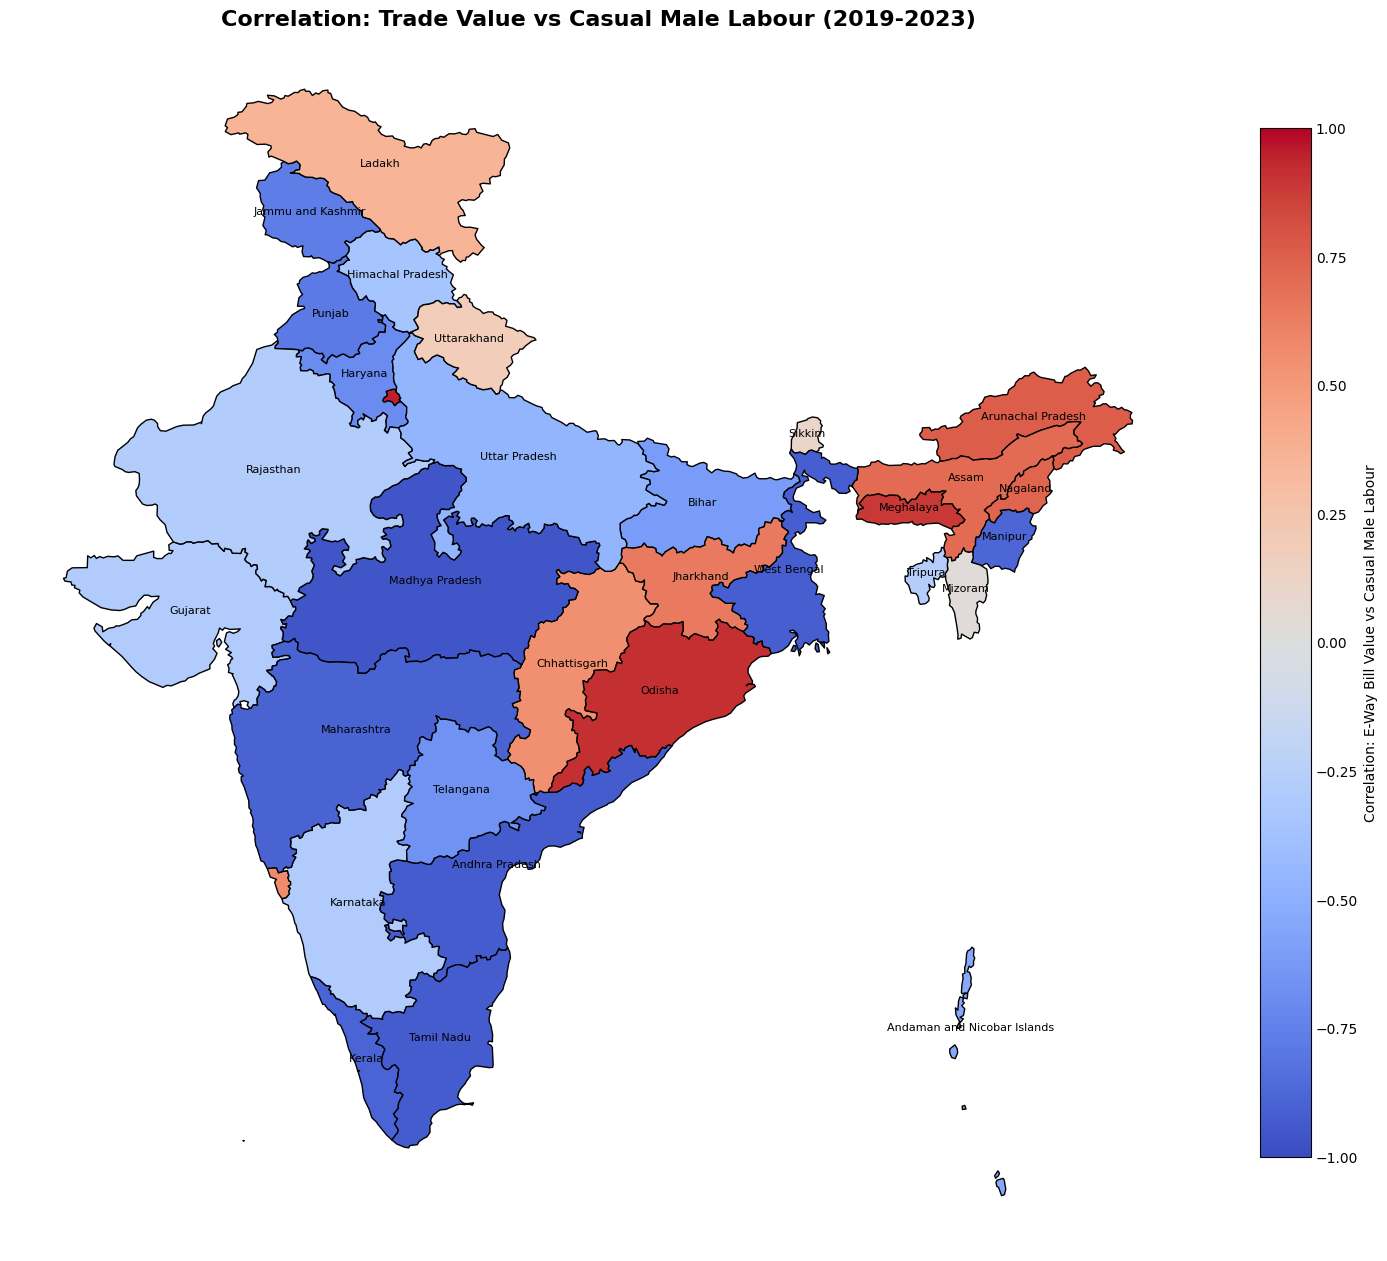

Generating plot for: Casual Female Labour


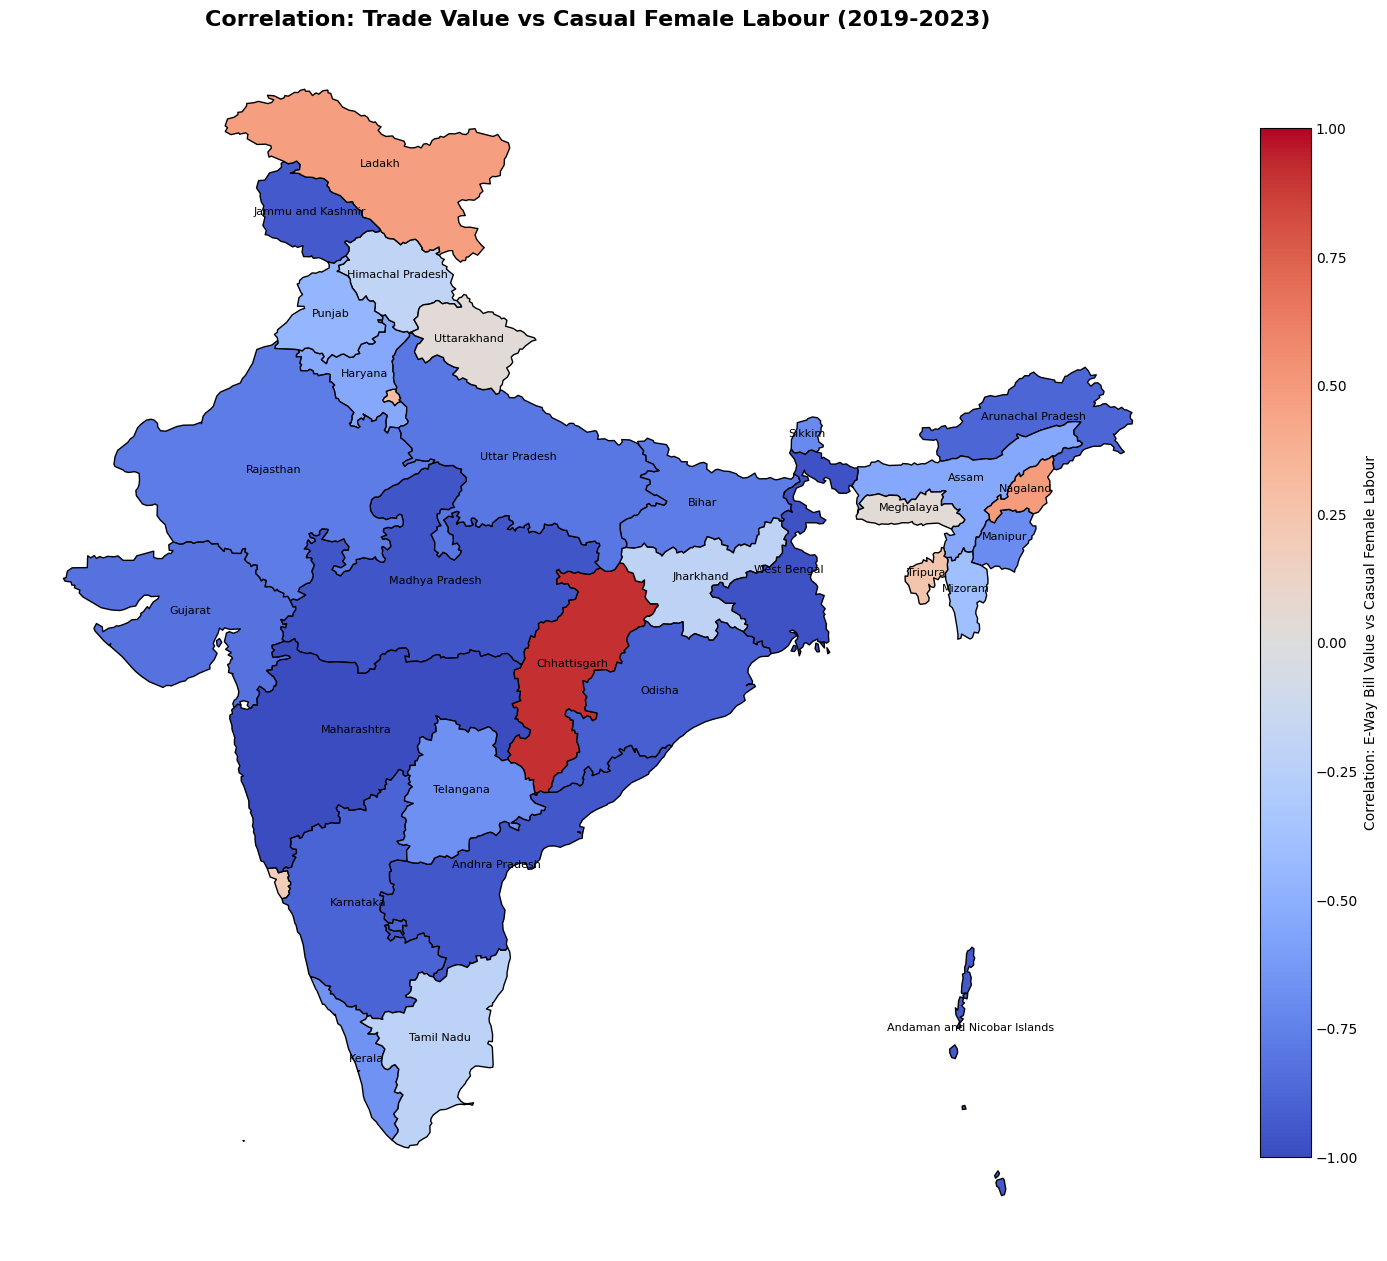

Generating plot for: Casual Overall Labour


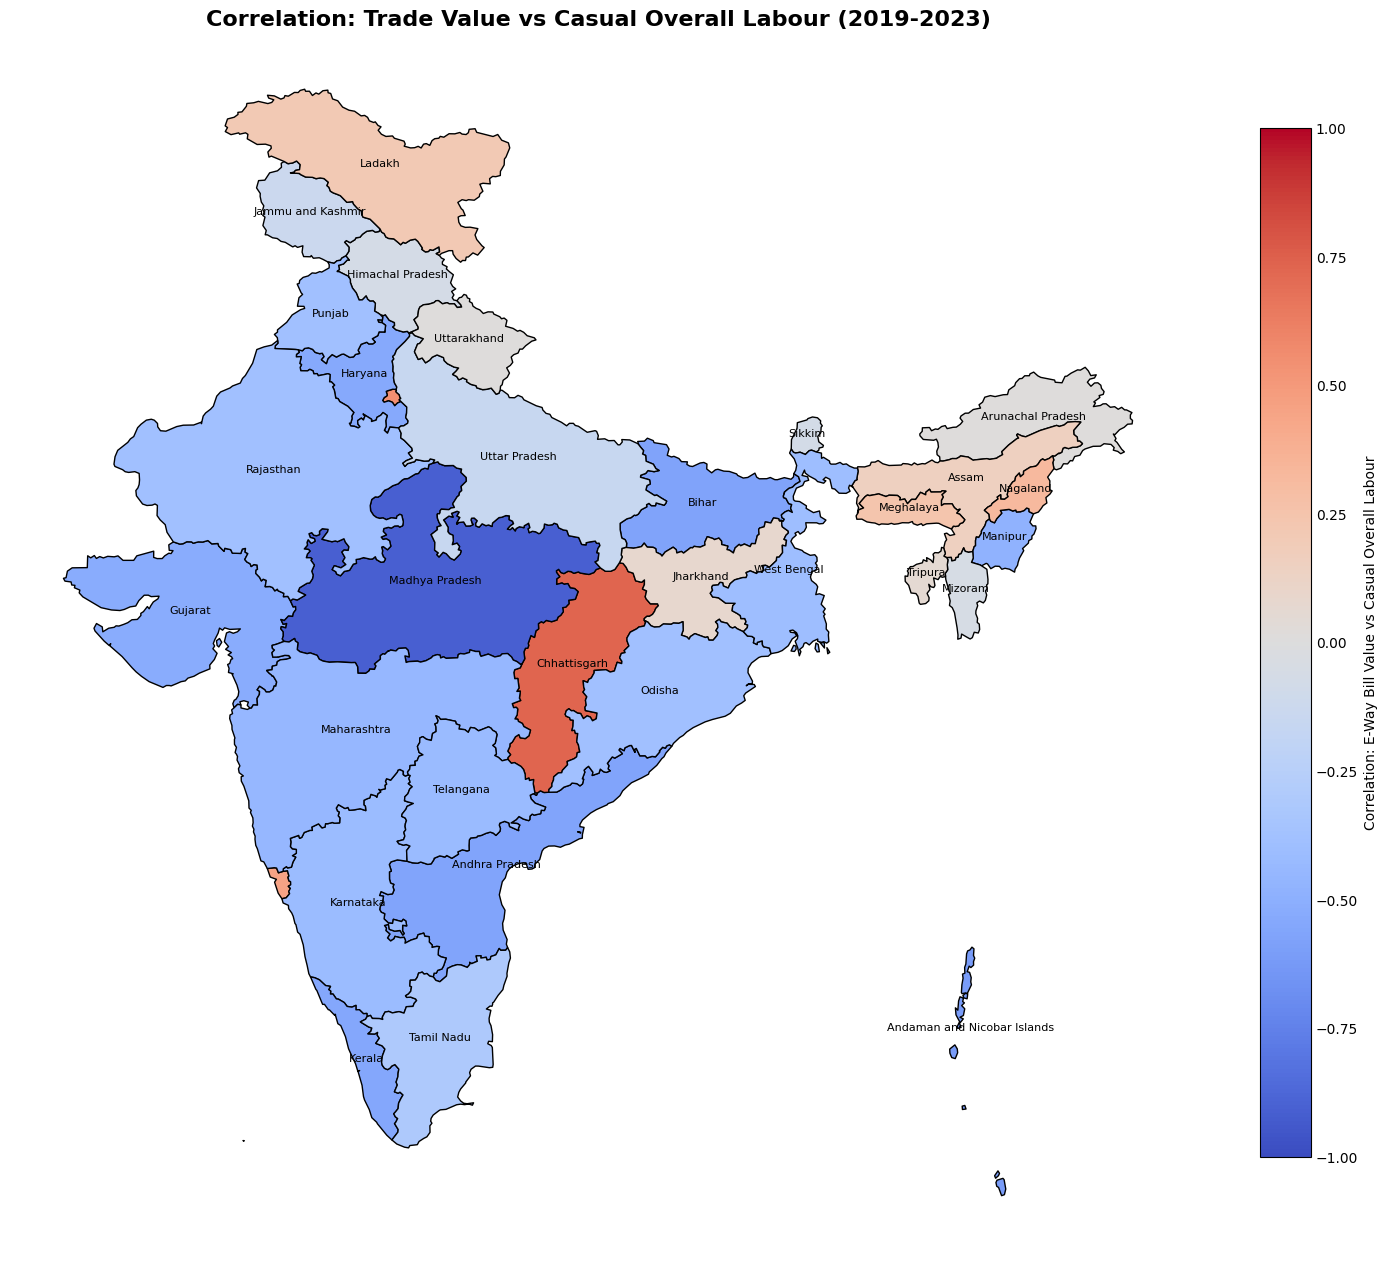

Generating plot for: Formal Male Labour


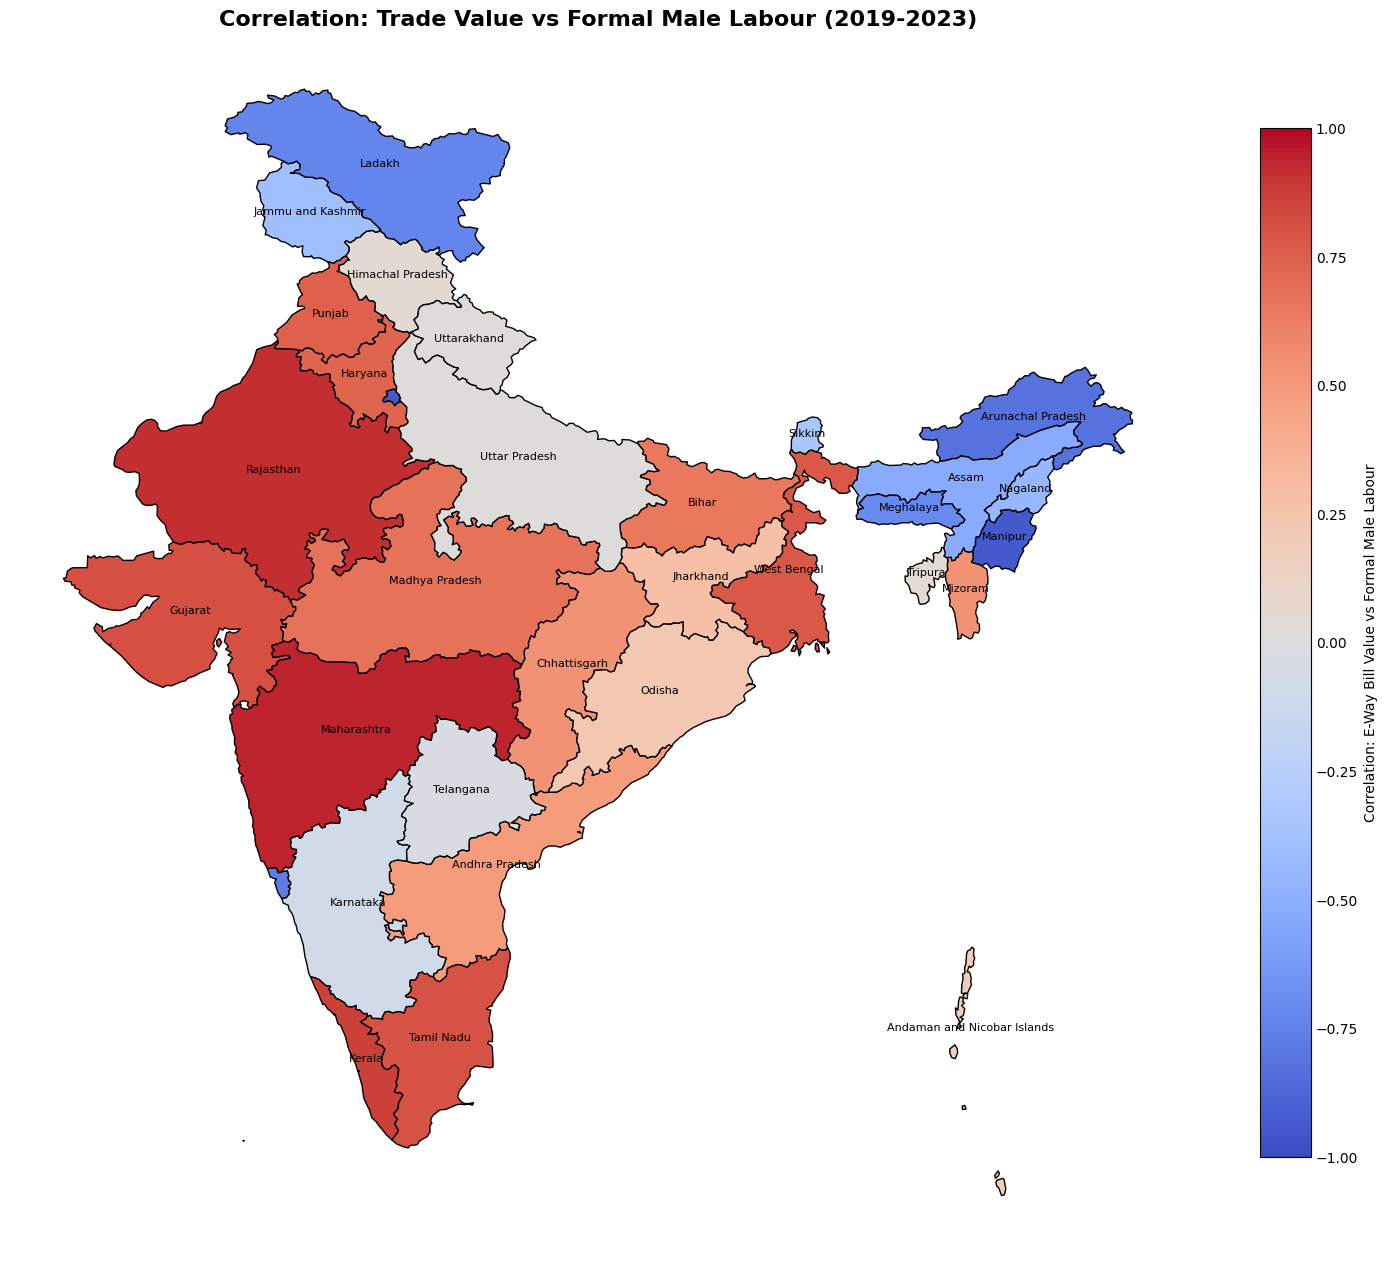

Generating plot for: Formal Female Labour


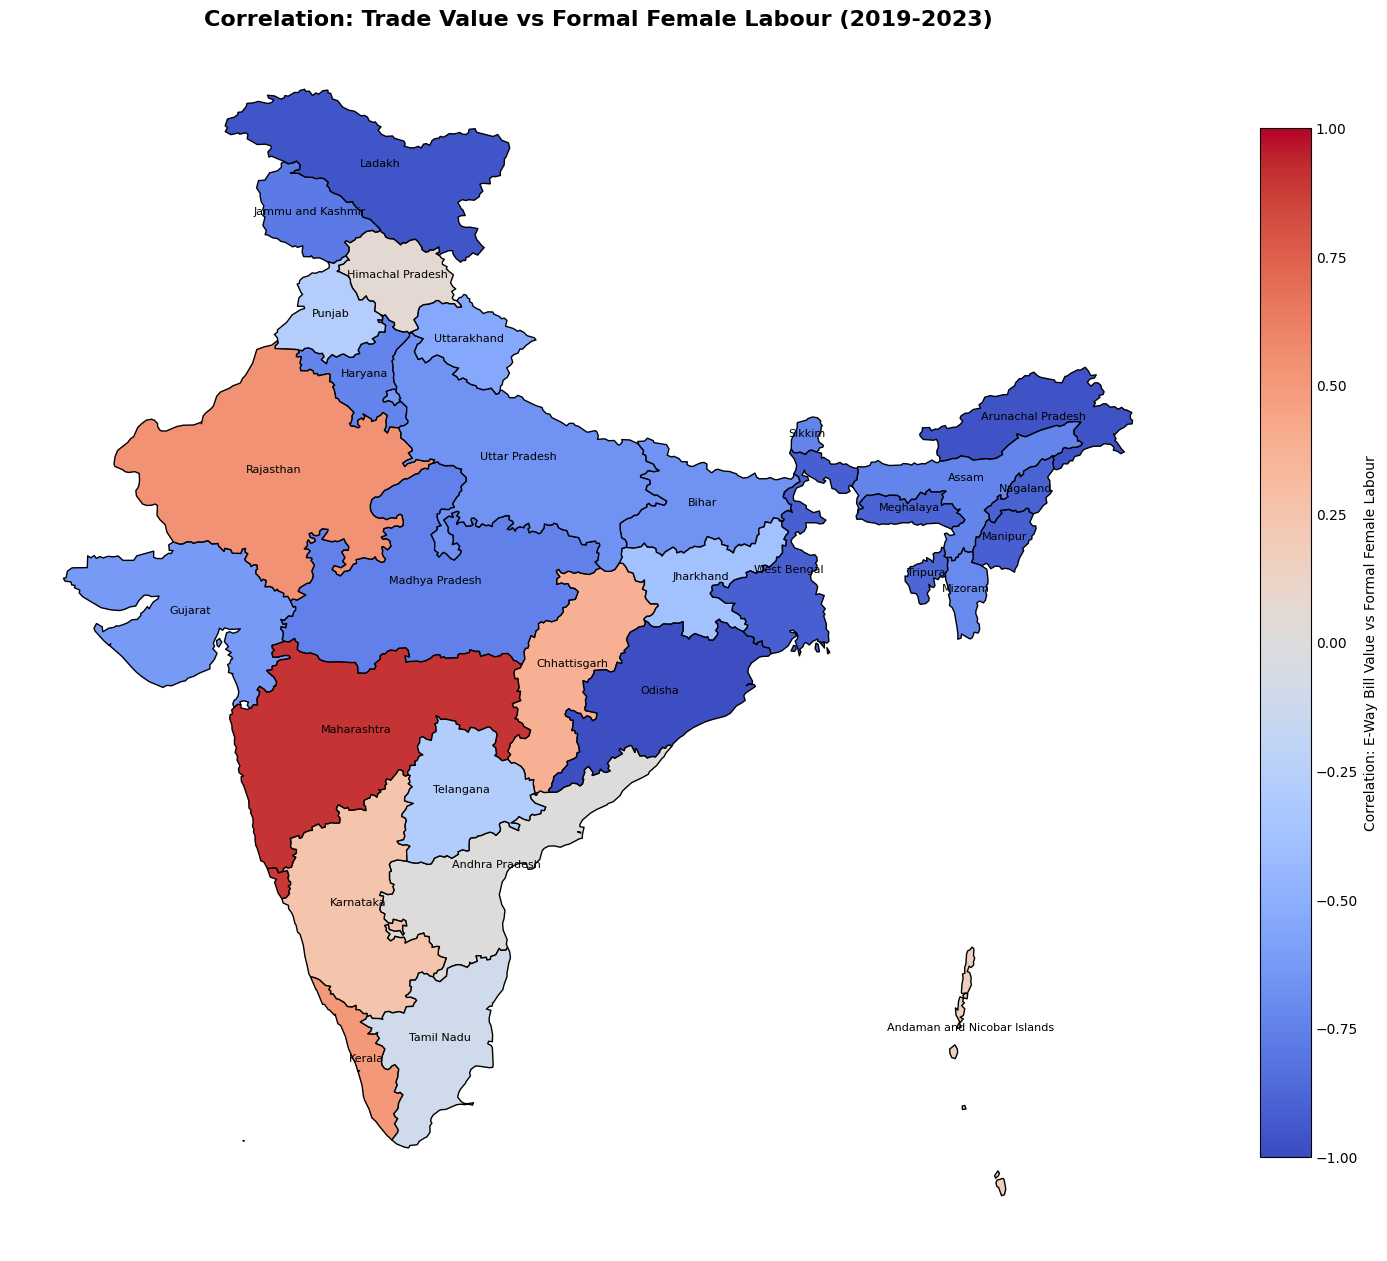

Generating plot for: Formal Overall Labour


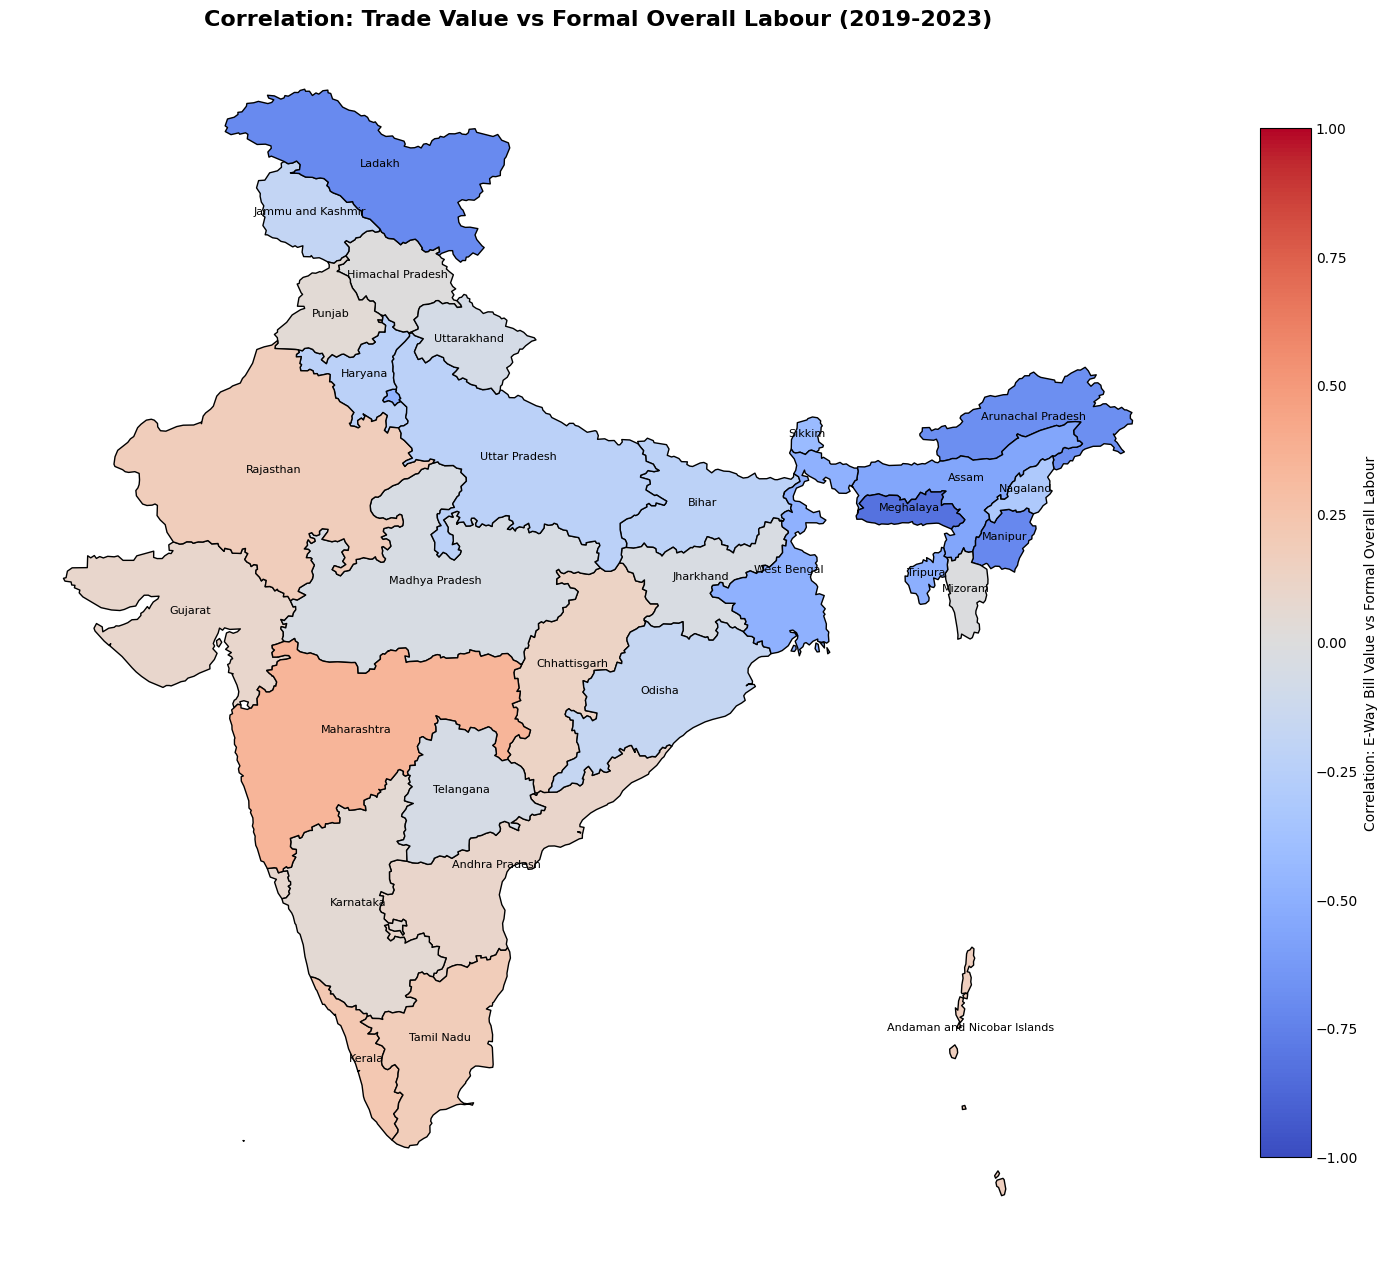

In [50]:
# Generating the Plots for each of these correlations


def plot_employment_correlation_map(correlation_data, correlation_type, gdf_pl):
    # Extract data for the specific correlation type
    data = {"state": [], "value": []}
    for state, metrics in correlation_data.items():
        val = metrics.get(correlation_type)
        if val is not None:
            data["state"].append(state)
            data["value"].append(val)
    
    # Create Polars DataFrame
    df = pl.DataFrame(data)
    
    # Join with GeoJSON data
    # Note: Assuming 'state' in df matches 'st_nm' in gdf_pl (both Title Case)
    merged_pl = df.join(
        gdf_pl, 
        left_on="state", 
        right_on="st_nm", 
        how="inner"
    ).select(
        pl.col("state").alias("st_nm"),
        pl.col("value"),
        pl.col("geometry")
    )
    
    # Convert to Pandas and then GeoDataFrame
    merged_pandas = merged_pl.to_pandas()
    merged_pandas['geometry'] = merged_pandas['geometry'].apply(wkt.loads)
    merged_gdf = gpd.GeoDataFrame(merged_pandas, geometry='geometry')
    
    # Dissolve by state name to handle any duplicate geometries
    merged_gdf = merged_gdf.dissolve(by='st_nm', aggfunc='first').reset_index()
    
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    merged_gdf.plot(
        column='value', 
        ax=ax, 
        legend=True,
        legend_kwds={
            'label': f"Correlation: E-Way Bill Value vs {correlation_type}", 
            'orientation': "vertical", 
            'shrink': 0.7
        },
        cmap='coolwarm', # Diverging colormap is good for correlation (-1 to 1)
        edgecolor='black',
        vmin=-1, # Fix scale from -1 to 1 for consistent comparison
        vmax=1
    )
    
    # Add Labels
    for idx, row in merged_gdf.iterrows():
        if row.geometry.area > 0.5: 
            plt.annotate(
                text=row['st_nm'], 
                xy=row.geometry.centroid.coords[0],
                horizontalalignment='center', 
                fontsize=8, 
                color='black'
            )
    
    ax.set_title(f'Correlation: Trade Value vs {correlation_type} (2019-2023)', fontsize=16, fontweight='bold')
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# 4. Generate plots for all 6 types
correlation_types = [
    "Casual Male Labour", 
    "Casual Female Labour", 
    "Casual Overall Labour",
    "Formal Male Labour", 
    "Formal Female Labour", 
    "Formal Overall Labour"
]

for c_type in correlation_types:
    print(f"Generating plot for: {c_type}")
    plot_employment_correlation_map(employment_correlations, c_type, gdf_pl)